# EUR / USD Currency Pair EDA

# Data Understanding

In [1]:
#Import libraries
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('ggplot')
import seaborn as sns
import statsmodels.api as sm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
import collections
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Set font and plot size to be larger
plt.rcParams.update({'font.size': 20, 'figure.figsize': (10, 8)})

from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
#import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
#acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import math
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import sklearn.metrics as metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#Import csv file
df = pd.read_csv('eurusd_hour.csv',parse_dates=True)
df

,Date,Time,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
0,2005-05-02,00:00,1.28520,1.28520,1.28400,1.28440,-0.00080,1.28540,1.28540,1.28420,1.28460,-0.00080
1,2005-05-02,01:00,1.28440,1.28480,1.28390,1.28420,-0.00020,1.28460,1.28500,1.28410,1.28440,-0.00020
2,2005-05-02,02:00,1.28430,1.28540,1.28410,1.28510,0.00080,1.28450,1.28560,1.28430,1.28530,0.00080
3,2005-05-02,03:00,1.28510,1.28590,1.28500,1.28510,0.00000,1.28530,1.28610,1.28520,1.28530,0.00000
4,2005-05-02,04:00,1.28520,1.28590,1.28490,1.28550,0.00030,1.28540,1.28610,1.28510,1.28570,0.00030
...,...,...,...,...,...,...,...,...,...,...,...,...
93079,2020-04-29,18:00,1.08620,1.08851,1.08611,1.08713,0.00093,1.08660,1.08865,1.08640,1.08726,0.00066
93080,2020-04-29,19:00,1.08711,1.08823,1.08659,1.08748,0.00037,1.08725,1.08837,1.08675,1.08760,0.00035
93081,2020-04-29,20:00,1.08747,1.08788,1.08691,1.08708,-0.00039,1.08758,1.08810,1.08706,1.08808,0.00050
93082,2020-04-29,21:00,1.08708,1.08740,1.08699,1.08714,0.00006,1.08808,1.08814,1.08763,1.08766,-0.00042


In [7]:
#Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

Dataset consists of 93084 rows of data. For shorter training time grouping data is needed.

### How to Group Data (Subsetting)

Group By 1 Day Interval

In [9]:
#Group by date and take the last value of every 1-day
test_1d = df.groupby(pd.Grouper(key='Date', freq='1D')).last().reset_index()
#drop time
test_1d = test_1d.drop(['Time'], axis=1)
#Check missing values
print(test_1d.isnull().sum())
#Print total rows
print("Total rows: {0}".format(len(test_1d)))

Date      0
BO      805
BH      805
BL      805
BC      805
BCh     805
AO      805
AH      805
AL      805
AC      805
ACh     805
dtype: int64
Total rows: 5477


Imputing approximately 15% of data (805/5477) is undesirable.

In [11]:
#Group by date and take the last value of every 2-day
test_2d = df.groupby(pd.Grouper(key='Date', freq='2D')).last().reset_index()
#drop time
test_2d = test_2d.drop(['Time'], axis=1)
#Check missing values
print(test_2d.isnull().sum())
#Print total rows
print("Total rows: {0}".format(len(test_2d)))

Date    0
BO      8
BH      8
BL      8
BC      8
BCh     8
AO      8
AH      8
AL      8
AC      8
ACh     8
dtype: int64
Total rows: 2739


Grouping by 2-day interval only requires us to impute approximately 0.3% of data (8/2739). Therefore Original Dataset is grouped into 2-day interval.

In [12]:
df=test_2d
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2739 non-null   datetime64[ns]
 1   BO      2731 non-null   float64       
 2   BH      2731 non-null   float64       
 3   BL      2731 non-null   float64       
 4   BC      2731 non-null   float64       
 5   BCh     2731 non-null   float64       
 6   AO      2731 non-null   float64       
 7   AH      2731 non-null   float64       
 8   AL      2731 non-null   float64       
 9   AC      2731 non-null   float64       
 10  ACh     2731 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 235.5 KB


# Is Time Equally spaced?

In [13]:
#Make Date the index
df = df.set_index('Date')

#Is index increasing?
print(df.index.is_monotonic_increasing)

#Is the index equally spaced?
df.index.to_series().diff().value_counts()

True


2 days    2738
Name: Date, dtype: int64

## Common Words Found In Forex News

In [63]:
df_clean = pd.read_csv('dataset_cleaned.csv')
df_clean.head()

,clean_text
0,forex u dollar rises consumer optimism falls r...
1,forex upbeat u data help dollar sterling reign...
2,forex u dollar remains steady jobless claims w...
3,forex dollar pushes higher pound slips risk se...
4,world stocks rise sterling ahead may vote reut...


In [64]:
# split sentences into words
tokenizer = Tokenizer(num_words=500000)
tokenizer.fit_on_texts(df_clean['clean_text'].values)
word_index = tokenizer.word_index

In [65]:
forex_text = df_clean.clean_text

forex_text = ' '.join(str(v) for v in forex_text)

In [66]:
# filter stopwords and noises
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
STOPWORDS.update(["dollar","u","euro","week"])

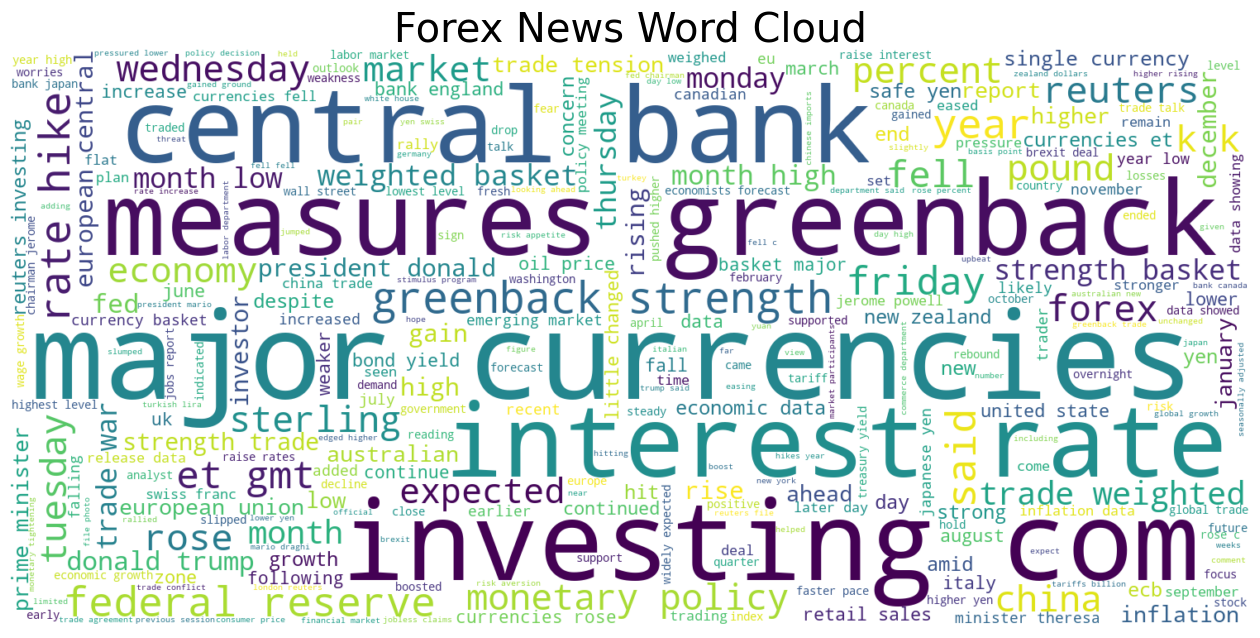

In [67]:
#Forex News word cloud
plt.figure(figsize = (16,14))
wc1 = WordCloud(background_color="white", min_font_size = 10,  max_words = 4000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(forex_text)
plt.imshow(wc1,interpolation = 'bilinear')
plt.title("Forex News Word Cloud")
plt.axis("off")
plt.show()

## Data Preprocessing

In [14]:
#Missing values 
df.isnull().sum()

BO     8
BH     8
BL     8
BC     8
BCh    8
AO     8
AH     8
AL     8
AC     8
ACh    8
dtype: int64

In [15]:
#Interpolate Missing Values
df['BO']=df['BO'].interpolate()
df['BH']=df['BH'].interpolate()
df['BL']=df['BL'].interpolate()
df['BC']=df['BC'].interpolate()
df['BCh']=df['BCh'].interpolate()
df['AO']=df['AO'].interpolate()
df['AH']=df['AH'].interpolate()
df['AL']=df['AL'].interpolate()
df['AC']=df['AC'].interpolate()
df['ACh']=df['ACh'].interpolate()
df.isnull().sum()

BO     0
BH     0
BL     0
BC     0
BCh    0
AO     0
AH     0
AL     0
AC     0
ACh    0
dtype: int64

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BO,2739.0,1.265024,0.127043,1.04009,1.139640,1.27299,1.357840,1.59188
BH,2739.0,1.265742,0.127212,1.04056,1.140065,1.27374,1.358480,1.59343
BL,2739.0,1.264388,0.126944,1.03976,1.139015,1.27223,1.357020,1.59169
BC,2739.0,1.265061,0.127128,1.04019,1.139345,1.27291,1.357640,1.59333
BCh,2739.0,0.000038,0.001029,-0.00864,-0.000420,0.00003,0.000450,0.00737
AO,2739.0,1.265345,0.127127,1.04031,1.139950,1.27344,1.358050,1.59288
AH,2739.0,1.266078,0.127281,1.04072,1.140350,1.27426,1.358935,1.59443
AL,2739.0,1.264721,0.127011,1.03994,1.139530,1.27277,1.357220,1.59269
AC,2739.0,1.265446,0.127150,1.04036,1.139915,1.27327,1.357960,1.59433
ACh,2739.0,0.000101,0.001031,-0.00864,-0.000320,0.00010,0.000520,0.00742


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


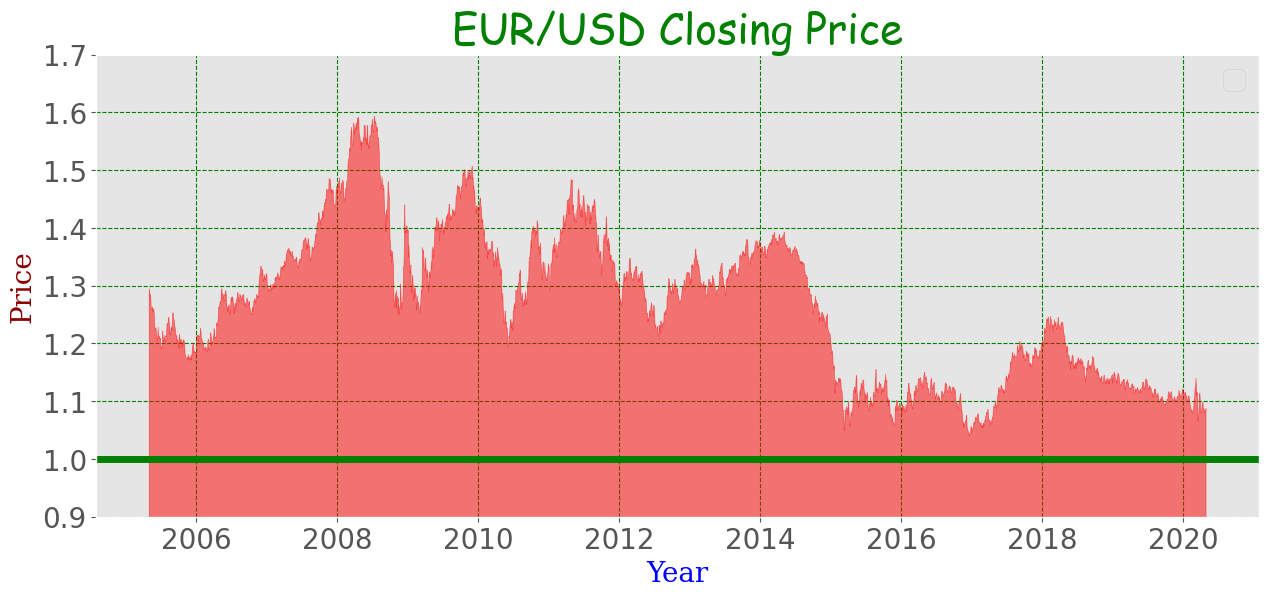

In [17]:
#Area Chart
tfont={'family':'cursive','color':'green','size':30}
xfont = {'family':'serif','color':'blue','size':20}
yfont = {'family':'serif','color':'darkred','size':20}
plt.figure(figsize=(15,6))
plt.fill_between(df.index,df['BC'],color='red',alpha=0.5)
plt.title('EUR/USD Closing Price',fontdict = tfont)
plt.legend()
plt.xlabel("Year",fontdict = xfont)
plt.ylabel("Price",fontdict = yfont)
plt.ylim((0.9,1.7))
plt.grid(color = 'green', linestyle = '--', linewidth = 0.8)
#Add a stright line accross 1.0
plt.axhline(y=1.0, color='g', linestyle='-' ,linewidth=5)
plt.show()

## Outliers

In [18]:
#Find skewness and kurtosis
#Skewness Checks signifies the extent of symmetry (Positively Skewed: Skew>0, Negatively Skewed: Skew<0)
#Kurtosis measures degree of peakedness (Heavy Tails/Leptokuric: Kurt>0 = Outliers More Possible, Mesokuric: Kurt=0, Light Tail/Platykurtic: Kurt<0 = Outlier less likely)
#Heavy Tails: many observations with values that are far from the mean
#Light Tails: few observations with values that are far from the mean
data_numerical=df[['BO','BH','BL','BC','BCh','AO','AH','AL','AC','ACh']]
skewness_array=[]
for i in data_numerical:
   
    skewness_array.append([i,data_numerical[i].skew(),data_numerical[i].kurt()])

skew_df=pd.DataFrame(skewness_array,columns=['Columns','Skewness','Kurtosis'])
skew_df

,Columns,Skewness,Kurtosis
0,BO,0.247070,-0.736448
1,BH,0.247668,-0.737717
2,BL,0.247684,-0.735435
3,BC,0.248071,-0.736469
4,BCh,0.096373,9.925468
5,AO,0.246803,-0.736464
6,AH,0.247509,-0.737735
7,AL,0.247475,-0.735160
8,AC,0.248299,-0.735857
9,ACh,-0.069894,9.735863


c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


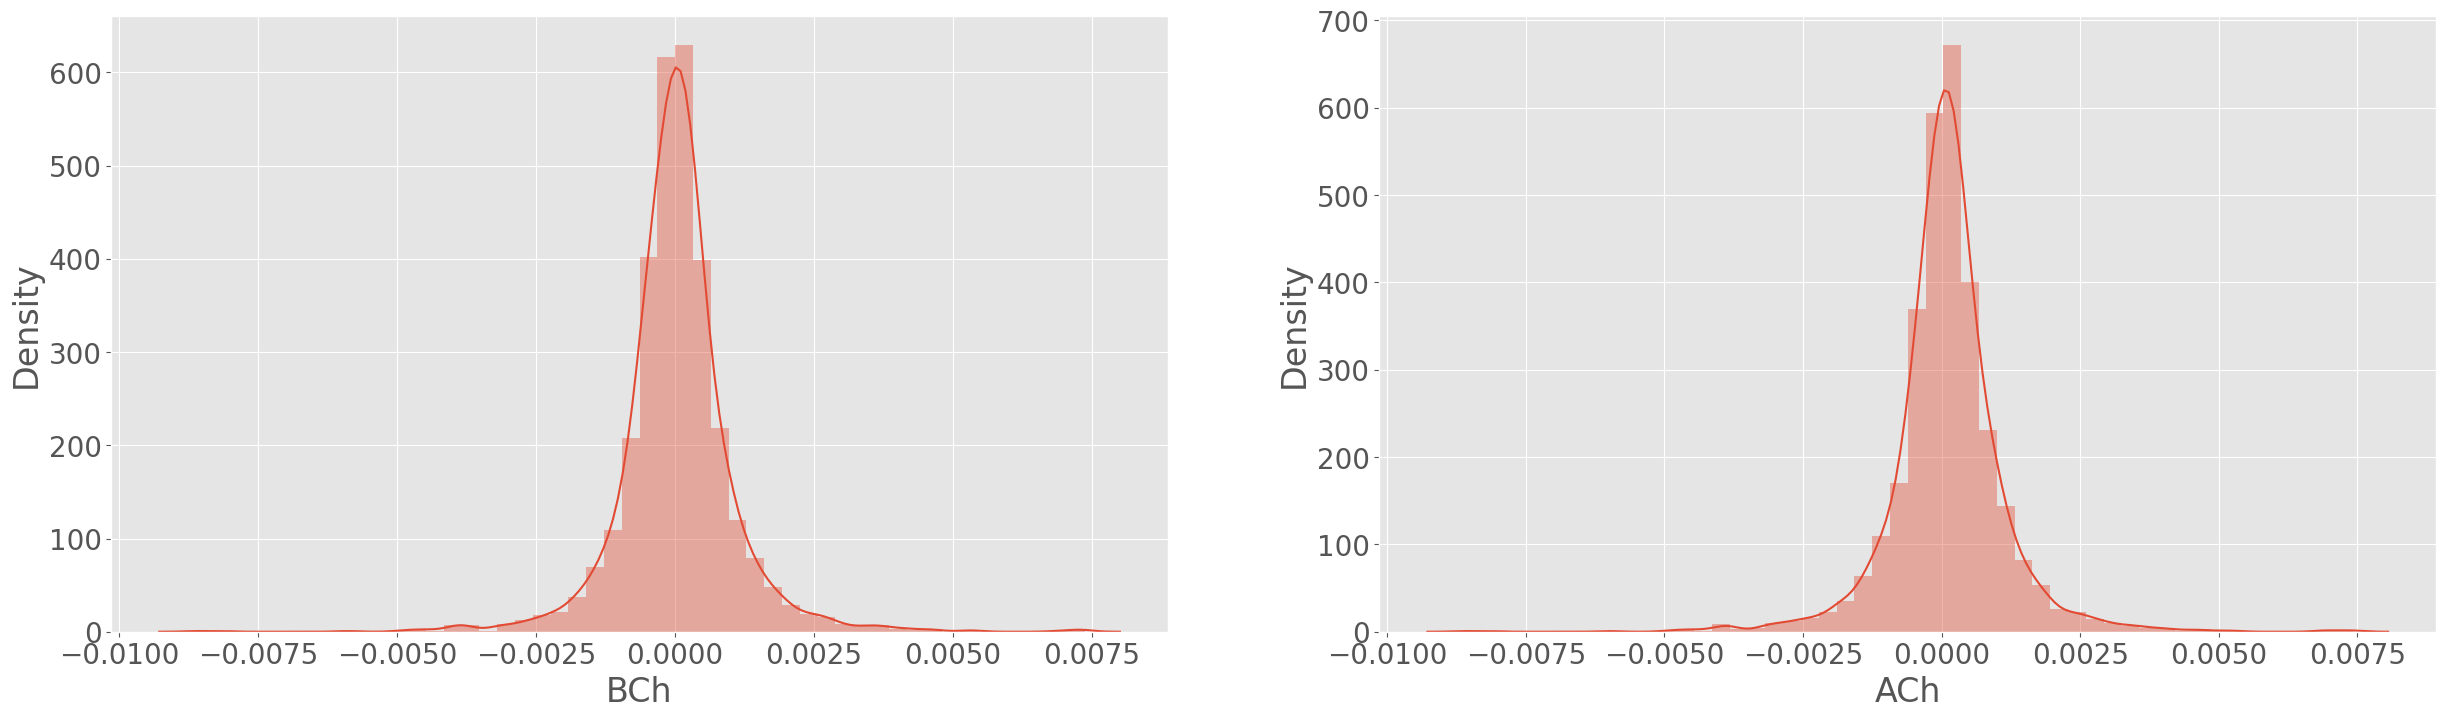

In [19]:
#Visualise skewness and kurtosis
fig, ax = plt.subplots(1, 2, figsize=(30, 8))
sns.distplot(df['BCh'], ax=ax[0])
sns.distplot(df['ACh'], ax=ax[1])
plt.show()

<AxesSubplot:>

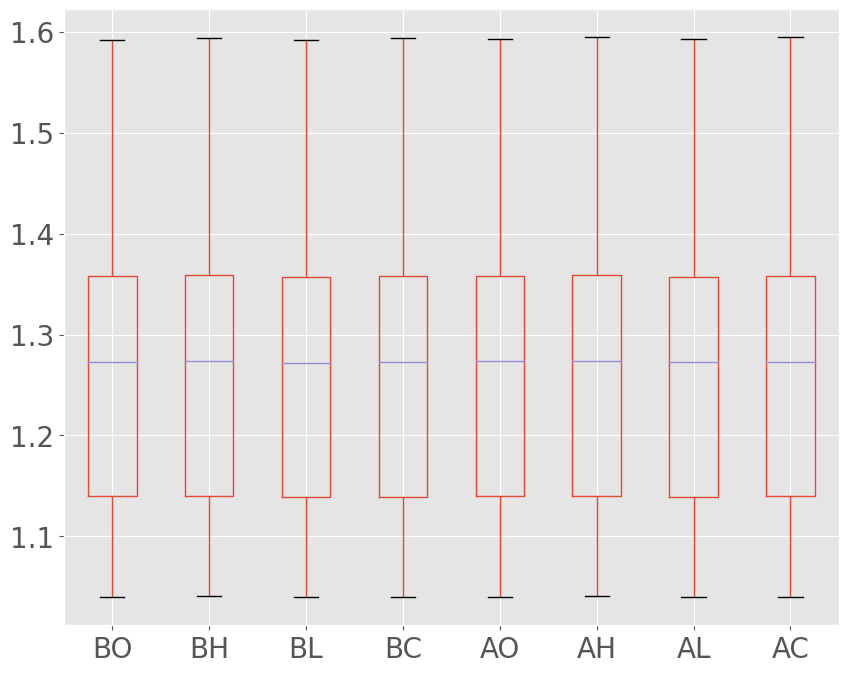

In [20]:
df.drop(['BCh','ACh'],axis=1).boxplot()

<AxesSubplot:>

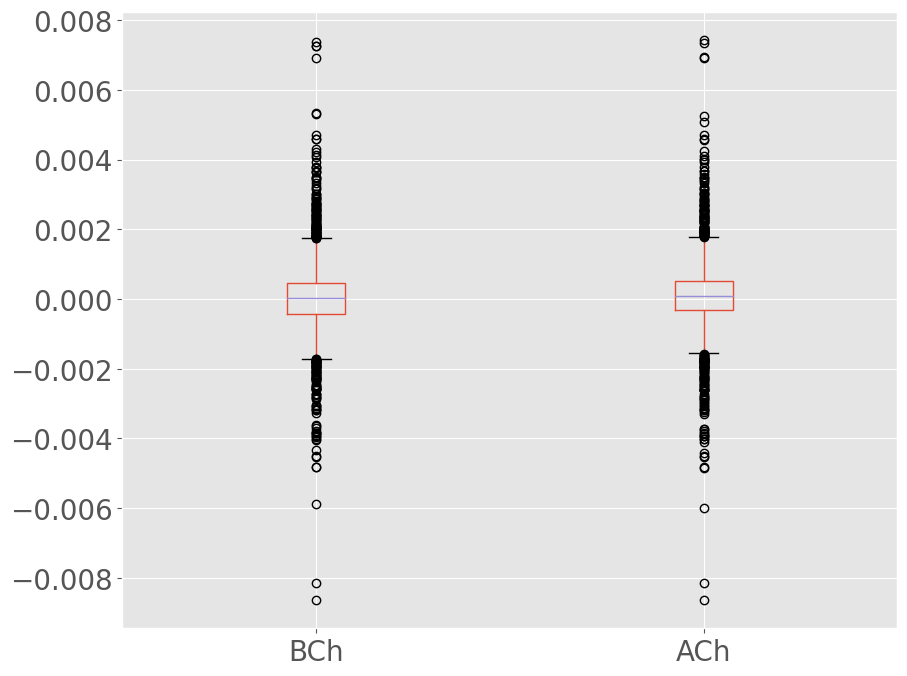

In [21]:
#box plot for BCh and ACh
df.drop(['BO','BH','BL','BC','AO','AH','AL','AC'],axis=1).boxplot()

Due to the nature of BCh and ACh being centered around 0 and financial data know to being volatile and unpredictable. BCh and ACh are more prone to exhibit extreme values.

### Feature Selection

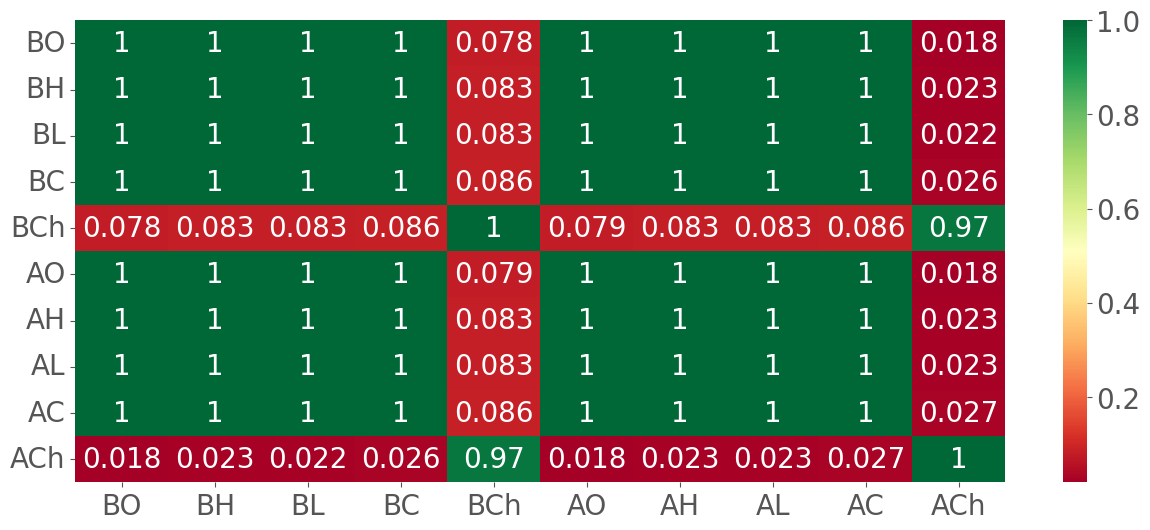

In [22]:
df_corr = df[['BO','BH','BL','BC','BCh','AO','AH','AL','AC','ACh']].corr()
#Corr Heatmap
plt.figure(figsize=(15,6))
sns.heatmap(df_corr,annot=True,cmap='RdYlGn')
plt.show()

## Conclusion
#### - Since this is a time-series dataset, only timestamp column and target variable is selected. 
#### - Asking Prices and Bidding Prices are reliant on each other. Asking Prices are dropped as their bidding price counterparts serve the same purpose.
#### - Out of Bid Columns 'BC' is selected as target variable.

In [23]:
#Drop Asking Price Columns and Bid Change
df = df.drop(['BO','BH','BL','BCh','AO','AH','AL','AC','ACh'], axis=1)

# Data Transformation

In [24]:
#Transfrom data into 3 forms (Original, Min Max Scaled, 1st Order Differenced)
#Orginal Data
original_df = df.copy()
#Min Max Scaled Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
#1st Order Differenced Data
diff_df = df.diff().dropna()

In [25]:
print(original_df.head())
print(scaled_df.head())
print(diff_df.head())

                 BC
Date               
2005-05-02  1.28783
2005-05-04  1.29450
2005-05-06  1.28140
2005-05-08  1.28450
2005-05-10  1.28030
                  BC
Date                
2005-05-02  0.447699
2005-05-04  0.459757
2005-05-06  0.436074
2005-05-08  0.441678
2005-05-10  0.434085
                 BC
Date               
2005-05-04  0.00667
2005-05-06 -0.01310
2005-05-08  0.00310
2005-05-10 -0.00420
2005-05-12 -0.01750


# Time-Series Analysis

### Visualise Time Series 

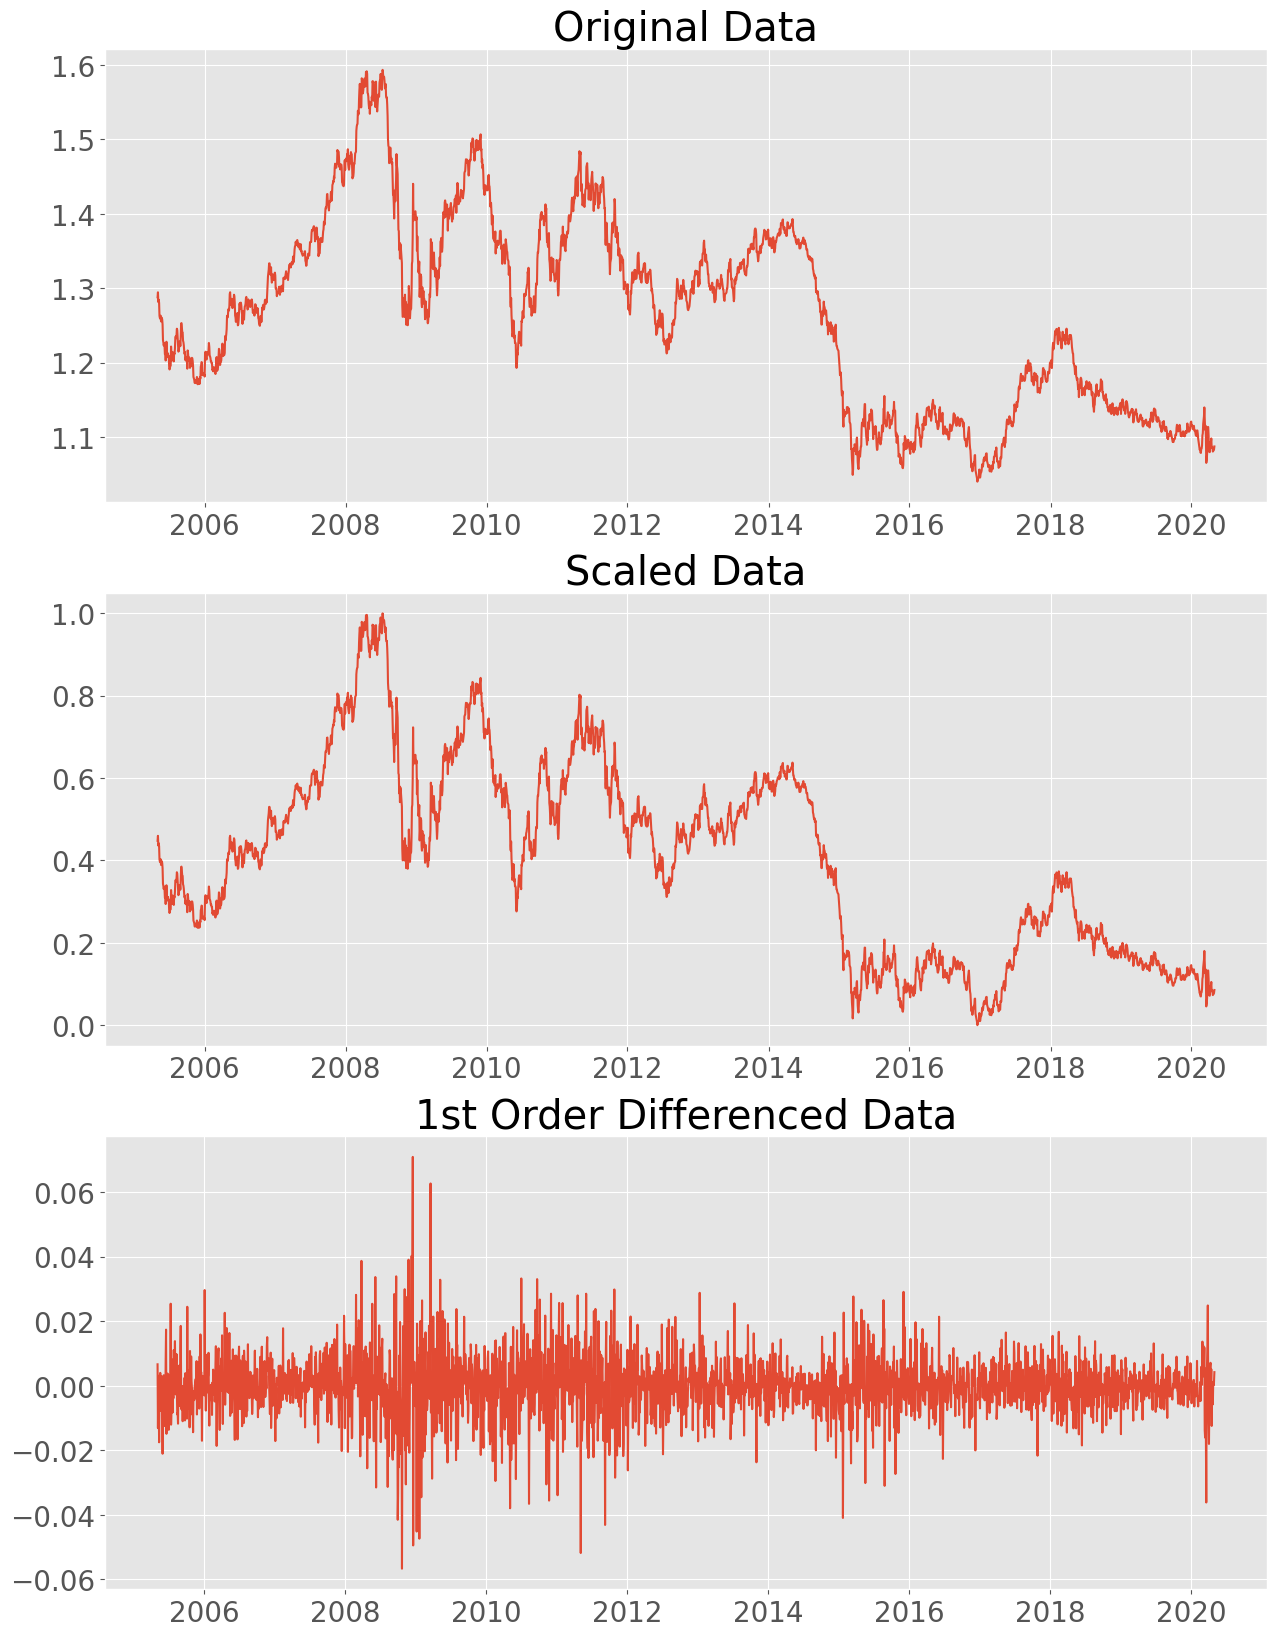

In [26]:
#Plot original_df against time and scaled_df against time and diff_df against time
fig, ax = plt.subplots(3, 1, figsize=(15, 20))
ax[0].plot(original_df)
ax[0].set_title('Original Data')
ax[1].plot(scaled_df)
ax[1].set_title('Scaled Data')
ax[2].plot(diff_df)
ax[2].set_title('1st Order Differenced Data')
plt.show()

# Stationary or Non-Stationary Time Series?

### Original

In [27]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
result=adfuller(original_df['BC'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")
#P-value= 0.45 > 0.05, therefore data is non-stationary and require preprocessing before ARIMA


ADF Statistic: -1.626040
p-value: 0.469564
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


### Scaled (Min Max Scaler)

In [28]:
#USING SCALED VALUES
result=adfuller(scaled_df['BC'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -1.626040
p-value: 0.469564
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


### 1st Order Differencing

In [29]:
#USING SCALED VALUES
result=adfuller(diff_df['BC'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -38.073147
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


In [30]:
#Spilt data into 95:5 original, scaled and differenced
original_train = original_df.iloc[:int(original_df.shape[0]*0.95)]
original_test = original_df.iloc[int(original_df.shape[0]*0.95):]
scaled_train = scaled_df.iloc[:int(scaled_df.shape[0]*0.95)]
scaled_test = scaled_df.iloc[int(scaled_df.shape[0]*0.95):]
diff_train = diff_df.iloc[:int(diff_df.shape[0]*0.95)]
diff_test = diff_df.iloc[int(diff_df.shape[0]*0.95):]

# Building ARIMA Model

### Arima on Original Dataset

In [15]:
stepwise_fit = auto_arima(original_train, start_p=0, start_q=0, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, stepwise=True, seasonal=True, 
                          information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=5)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-15154.291, Time=0.28 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-15897.988, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=3.59 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-15152.297, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-16177.684, Time=1.24 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-16339.191, Time=1.99 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=-16431.768, Time=3.12 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=-16496.665, Time=4.94 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=-16438.977, Time=13.06 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=-16421.714, Time=9.95 sec
 ARIMA(0,1,0)(5,1,0)[7]             : AIC=-16498.658, Time=3.51 sec
 ARIMA(0,1,0)(4,1,0)[7]             : AIC=-16433.713, Time=2.15 sec
 ARIMA(0,1,0)(5,1,1)[7]             : AIC=-16443.122, Time=12.13 sec
 ARIMA(0,1,0)(4,1,1)[7]             : AIC=-16380.652, Time=5.74 sec
 ARIMA(0,1

In [43]:
#fit arima model to training set
original_model_arima = ARIMA(original_train, order=(0,1,0))
model_fit_original_arima = original_model_arima.fit()
predictions_original_arima = model_fit_original_arima.predict()
model_fit_original_arima.summary()

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     BC   No. Observations:                 2602
Model:                 ARIMA(0, 1, 0)   Log Likelihood                8487.296
Date:                Tue, 09 May 2023   AIC                         -16972.593
Time:                        15:01:00   BIC                         -16966.729
Sample:                    05-02-2005   HQIC                        -16970.468
                         - 07-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.572e-05   1.23e-06     69.796      0.000    8.33e-05    8.81e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3261.57
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE:  0.026890802039500453
R2:  0.9534881454437942
RSS: 1.881546
Plotting ARIMA model


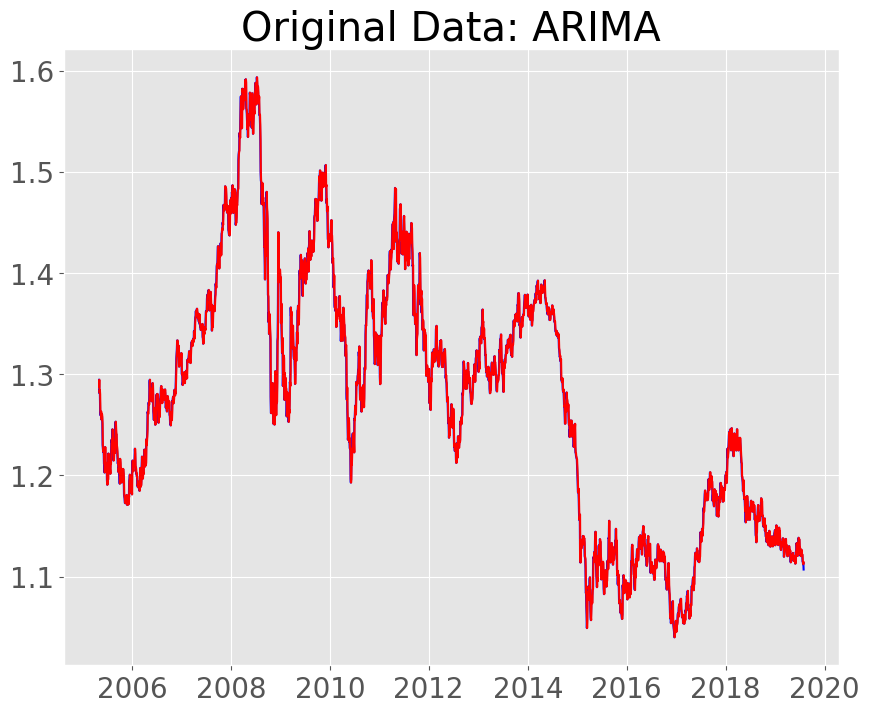

In [44]:
#Check RMSE of predictions
# Calculate the RMSE
rmse_original_arima = sqrt(mean_squared_error(original_train,predictions_original_arima))
print('RMSE: ', rmse_original_arima)
#Check R-squared values 
r2_original_arima = r2_score(original_train, predictions_original_arima)
print('R2: ', r2_original_arima)
plt.plot(original_train[1:], color='blue')
plt.plot(model_fit_original_arima.fittedvalues[1:], color='red')
rss_original_arima = sum((model_fit_original_arima.fittedvalues - original_train['BC'])**2)
plt.title('Original Data: ARIMA')
print('RSS: %4f'% rss_original_arima)
print('Plotting ARIMA model')

### Arima on Scaled Dataset

In [45]:
stepwise_fit = auto_arima(scaled_train, start_p=0, start_q=0, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, stepwise=True, seasonal=True, 
                          information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=5)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-12082.247, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-12826.052, Time=0.74 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=5.75 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-12080.253, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-13105.641, Time=1.00 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-13267.148, Time=2.19 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=-13359.845, Time=3.04 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=-13424.634, Time=5.33 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=-13368.665, Time=11.86 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=-13396.301, Time=9.44 sec
 ARIMA(0,1,0)(5,1,0)[7]             : AIC=-13426.614, Time=3.29 sec
 ARIMA(0,1,0)(4,1,0)[7]             : AIC=-13361.669, Time=1.77 sec
 ARIMA(0,1,0)(5,1,1)[7]             : AIC=-13369.827, Time=10.40 sec
 ARIMA(0,1,0)(4,1,1)[7]             : AIC=-13614.640, Time=7.62 sec
 ARIMA(0,1

In [58]:
#fit arima model to training set
scaled_model_arima = ARIMA(scaled_train, order=(0,1,0))
model_fit_scaled_arima = scaled_model_arima.fit()
predictions_scaled_arima = model_fit_scaled_arima.predict()
model_fit_scaled_arima.summary()

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     BC   No. Observations:                 2602
Model:                 ARIMA(0, 1, 0)   Log Likelihood                6947.129
Date:                Tue, 09 May 2023   AIC                         -13892.259
Time:                        15:06:34   BIC                         -13886.395
Sample:                    05-02-2005   HQIC                        -13890.134
                         - 07-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   4.01e-06     69.796      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3261.57
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE:  0.018899468414248582
R2:  0.9929704835143116
RSS: 0.929408
Plotting ARIMA model


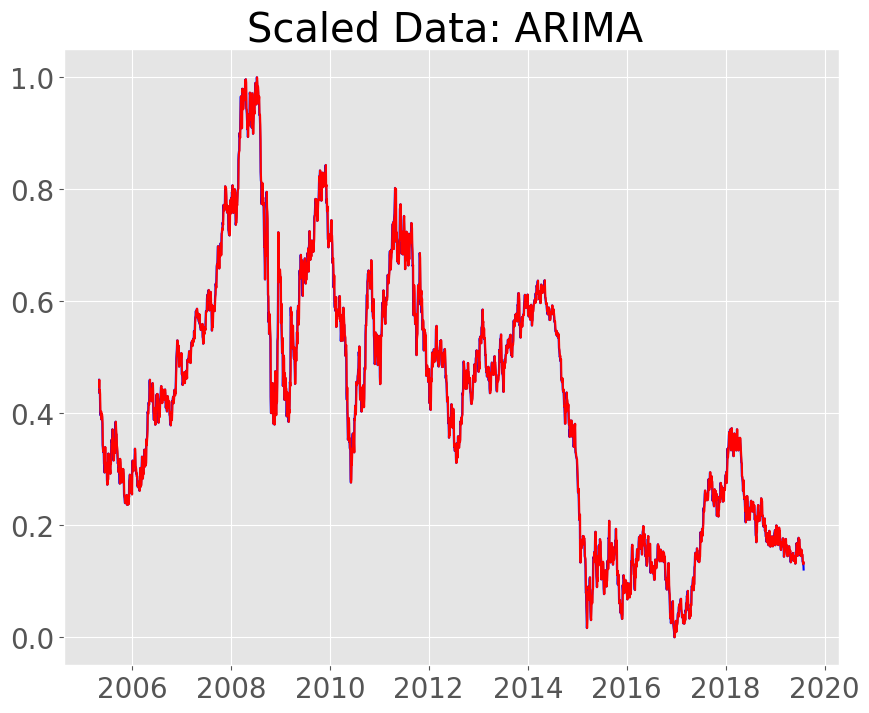

In [59]:
#Check RMSE of predictions
# Calculate the RMSE
rmse_scaled_arima = sqrt(mean_squared_error(scaled_train,predictions_scaled_arima))
print('RMSE: ', rmse_scaled_arima)
#Check R-squared values 
r2_scaled_arima = r2_score(scaled_train,predictions_scaled_arima)
print('R2: ', r2_scaled_arima)
plt.plot(scaled_train[1:], color='blue')
plt.plot(model_fit_scaled_arima.fittedvalues[1:], color='red')
rss_scaled_arima = sum((model_fit_scaled_arima.fittedvalues - scaled_train['BC'])**2)
plt.title('Scaled Data: ARIMA ')
print('RSS: %4f'% rss_scaled_arima)
print('Plotting ARIMA model')

### Arima on Differenced Dataset

In [31]:
stepwise_fit = auto_arima(diff_train, start_p=0, start_q=0, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, stepwise=True, seasonal=True, 
                          information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=5)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-13354.003, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-14774.164, Time=1.11 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=4.56 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-14041.863, Time=0.62 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-15074.757, Time=2.93 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-15226.492, Time=3.54 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=-15318.229, Time=3.72 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=-15370.756, Time=7.52 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=14.33 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=-15667.324, Time=8.44 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=6.83 sec
 ARIMA(1,1,0)(4,1,2)[7]             : AIC=inf, Time=14.43 sec
 ARIMA(1,1,0)(3,1,2)[7]             : AIC=inf, Time=13.92 sec
 ARIMA(1,1,0)(5,1,2)[7]             : AIC=inf, Time=26.98 sec
 ARIMA(0,1,0)(4,1,1)[7]             : AIC=i

In [61]:
#fit arima model to training set
diff_model = ARIMA(diff_train, order=(3,1,1))
model_fit_diff_arima = diff_model.fit()
predictions_diff_arima = model_fit_diff_arima.predict()
model_fit_diff_arima.summary()

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     BC   No. Observations:                 2601
Model:                 ARIMA(3, 1, 1)   Log Likelihood                8465.474
Date:                Tue, 09 May 2023   AIC                         -16920.949
Time:                        16:02:41   BIC                         -16891.632
Sample:                    05-04-2005   HQIC                        -16910.327
                         - 07-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0074      0.014      0.514      0.607      -0.021       0.036
ar.L2         -0.0324      0.017     -1.925      0.054      -0.065       0.001
ar.L3          0.0162      0.015      1.090      0.276      -0.013       0.045
ma.L1         -0.9717      0.005   -194.634      0.000      -0.982      -0.962
sigma2      8.428e-05   1.23e-06     68.700      0.000    8.19e-05    8.67e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):              3119.82
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE:  0.009324997634519373
R2:  -0.014098243916938813
RSS: 0.226171
Plotting ARIMA model


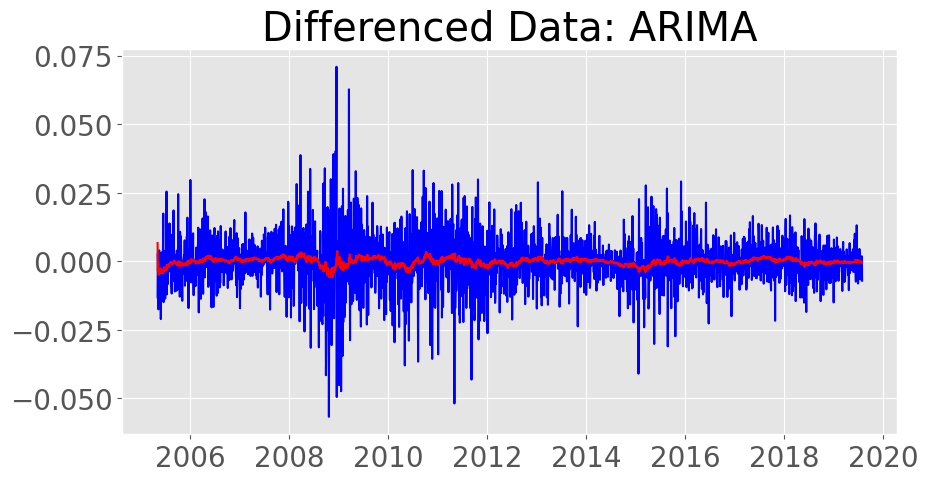

In [64]:
#Check RMSE of predictions
# Calculate the RMSE
#figsize
fig, ax = plt.subplots(figsize=(10, 5))
rmse_diff_arima = sqrt(mean_squared_error(diff_train,predictions_diff_arima))
print('RMSE: ', rmse_diff_arima)
#Check R-squared values 
r2_diff_arima = r2_score(diff_train,predictions_diff_arima)
print('R2: ', r2_diff_arima)
plt.plot(diff_train[1:], color='blue')
plt.plot(model_fit_diff_arima.fittedvalues[1:], color='red')
rss_diff_arima =sum((model_fit_diff_arima.fittedvalues - diff_train['BC'])**2)
plt.title('Differenced Data: ARIMA')
print('RSS: %4f'% rss_diff_arima)
print('Plotting ARIMA model')

# Building SARIMA Model

### SARIMA on Original Dataset

In [10]:
sori_model = auto_arima(original_df, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=7, stepwise=True, seasonal=True, information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

print(sori_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-16027.080, Time=0.45 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-16812.513, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.41 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-16025.227, Time=0.31 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-17108.890, Time=1.95 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-17283.726, Time=2.16 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=-17381.029, Time=5.95 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=-17448.413, Time=4.63 sec
 ARIMA(1,1,0)(6,1,0)[7]             : AIC=-17525.555, Time=7.33 sec
 ARIMA(1,1,0)(7,1,0)[7]             : AIC=-17558.695, Time=7.55 sec
 ARIMA(1,1,0)(8,1,0)[7]             : AIC=-17606.976, Time=17.76 sec
 ARIMA(1,1,0)(9,1,0)[7]             : AIC=-17633.805, Time=17.59 sec
 ARIMA(1,1,0)(10,1,0)[7]             : AIC=-17642.396, Time=23.63 sec
 ARIMA(1,1,0)(10,1,1)[7]             : AIC=-17632.120, Time=66.51 sec
 ARIMA

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)


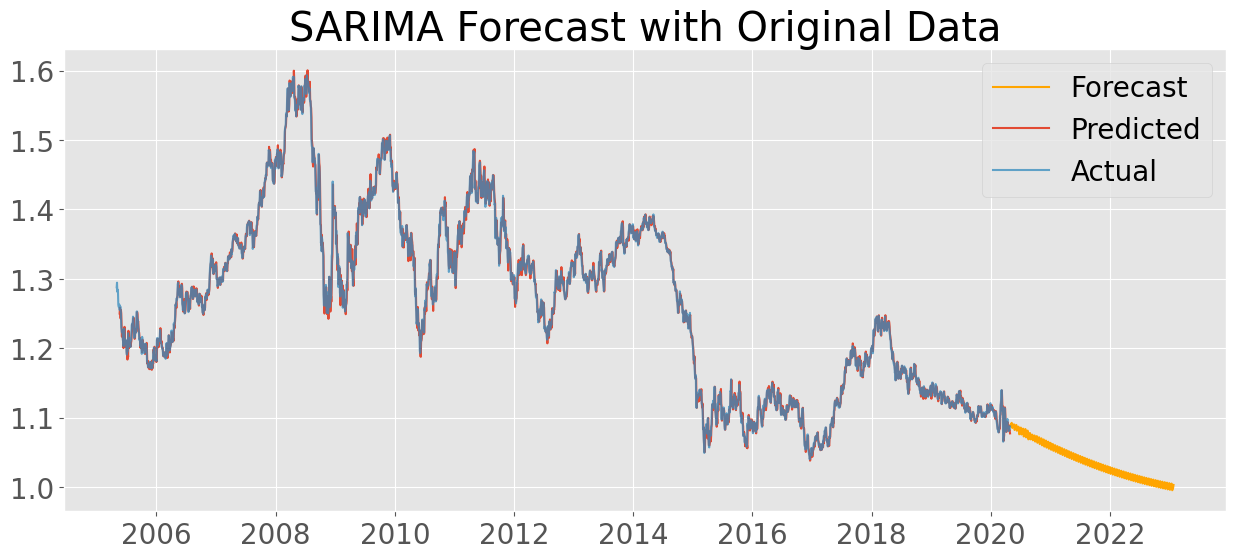

In [65]:
sori_model = SARIMAX(original_df, order=(0, 1, 0), seasonal_order=(10, 1, 0, 7), trend='c', enforce_invertibility=False)
sori_model_fit = sori_model.fit()

# Make predictions
sori_predictions = sori_model_fit.predict(start=0, end=len(original_df['BC'])-1, typ='levels')

#make forecast
sori_forecast = sori_model_fit.predict(start=len(original_df['BC']), end=len(original_df['BC'])+500, typ='levels')

# Plot actual vs predicted values
plt.figure(figsize=(15,6))
plt.title("SARIMA Forecast with Original Data")
plt.plot(sori_forecast.index, sori_forecast, label='Forecast', color='orange')
plt.plot(original_df.index[9:], sori_predictions[9:], label='Predicted', alpha=1)
plt.plot(original_df.index, original_df, label='Actual', alpha=0.75)

plt.legend()
plt.show()

In [67]:
rmse_original_sarima = sqrt(mean_squared_error(original_df,sori_predictions))
print('RMSE: ', rmse_original_sarima)


from sklearn.metrics import r2_score
r2_original_sarima = r2_score(original_df, sori_predictions)
print('R2: ', r2_original_sarima)

# Calculate residuals
y_true = original_df['BC'].iloc[-len(original_df):]

residuals = y_true - sori_predictions

# Calculate RSS
rss_original_sarima = np.sum(residuals**2)
print("RSS:", rss_original_sarima)

RMSE:  0.029120823105633614
R2:  0.9475092739550102
RSS: 2.3227331847395667


### SARIMA on Scaled Dataset

In [ ]:
sscaled_model = auto_arima(scaled_df, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=7, stepwise=True, seasonal=True, information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

print(sscaled_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-12792.789, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-13578.311, Time=0.69 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=3.06 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-12790.935, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-13874.612, Time=1.73 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-14049.436, Time=1.25 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=-14146.852, Time=3.82 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=-14214.122, Time=3.97 sec
 ARIMA(1,1,0)(6,1,0)[7]             : AIC=-14291.331, Time=8.32 sec
 ARIMA(1,1,0)(7,1,0)[7]             : AIC=-14324.444, Time=14.83 sec
 ARIMA(1,1,0)(8,1,0)[7]             : AIC=-14372.686, Time=10.95 sec
 ARIMA(1,1,0)(9,1,0)[7]             : AIC=-14399.515, Time=11.36 sec
 ARIMA(1,1,0)(10,1,0)[7]             : AIC=-14408.106, Time=19.98 sec
 ARIMA(1,1,0)(10,1,1)[7]             : AIC=-14397.832, Time=88.02 sec
 ARIM

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)


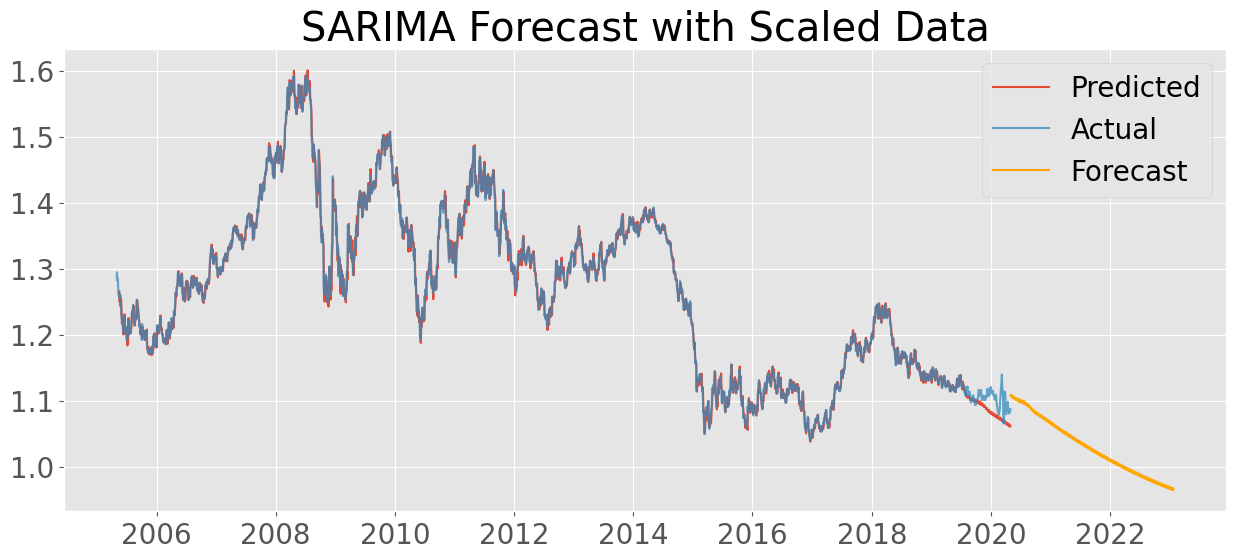

In [68]:
sscaled_model = SARIMAX(scaled_train, order=(0, 1, 0), seasonal_order=(10, 1, 0, 7), trend='c', enforce_invertibility=False)
sscaled_model_fit = sscaled_model.fit()

# Make predictions 
sscaled_predictions = sscaled_model_fit.predict(start=0, end=len(original_df)-1, typ='levels')

# Inverse scaling to obtain original scale
sscaled_predictions = scaler.inverse_transform(sscaled_predictions.values.reshape(-1, 1)).flatten()

# Generate future dates
sscaled_future_dates = pd.date_range(start='2020-05-01', periods=500, freq='2D')

# Use the SARIMAX model to forecast future values
sscaled_forecast = sscaled_model_fit.forecast(steps=500)

# Inverse scaling to obtain original scale for forecasted values
sscaled_forecast = scaler.inverse_transform(sscaled_forecast.values.reshape(-1, 1)).flatten()

# Generate future dates
sscaled_future_dates = pd.date_range(start='2020-05-01', periods=500, freq='2D')

# Plot actual vs predicted values
plt.figure(figsize=(15,6))
plt.title("SARIMA Forecast with Scaled Data")
plt.plot(original_df.index[8:], sscaled_predictions[8:], label='Predicted')
plt.plot(original_df.index, original_df, label='Actual', alpha=0.75)
plt.plot(sscaled_future_dates, sscaled_forecast, label='Forecast', color='orange')
plt.legend()
plt.show()

In [72]:
rmse_scaled_sarima = sqrt(mean_squared_error(original_df,sscaled_predictions))
print('RMSE: ', rmse_scaled_sarima)


from sklearn.metrics import r2_score
r2_scaled_sarima = r2_score(original_df, sscaled_predictions)
print('R2: ', r2_scaled_sarima)


y_true = original_df['BC'].iloc[-len(original_df):]

residuals = y_true - sscaled_predictions

# Calculate RSS
rss_scaled_sarima = np.sum(residuals**2)
print("RSS:", rss_scaled_sarima)

RMSE:  0.011929112137565326
R2:  0.9911917115216794
RSS: 0.3897698791938763


### SARIMA on Differenced Dataset

In [31]:
sdiff_model = auto_arima(diff_df, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=7, stepwise=True, seasonal=True, information_criterion='aic', trace=False, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

print(sdiff_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                 2738
Model:             SARIMAX(1, 1, 0)x(8, 1, [1, 2, 3], 7)   Log Likelihood                8315.116
Date:                                   Wed, 10 May 2023   AIC                         -16604.232
Time:                                           18:15:20   BIC                         -16527.375
Sample:                                       05-04-2005   HQIC                        -16576.454
                                            - 04-29-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4951      0.012    -41.159      0.000    

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 2D will be used.
  self._init_dates(dates, freq)


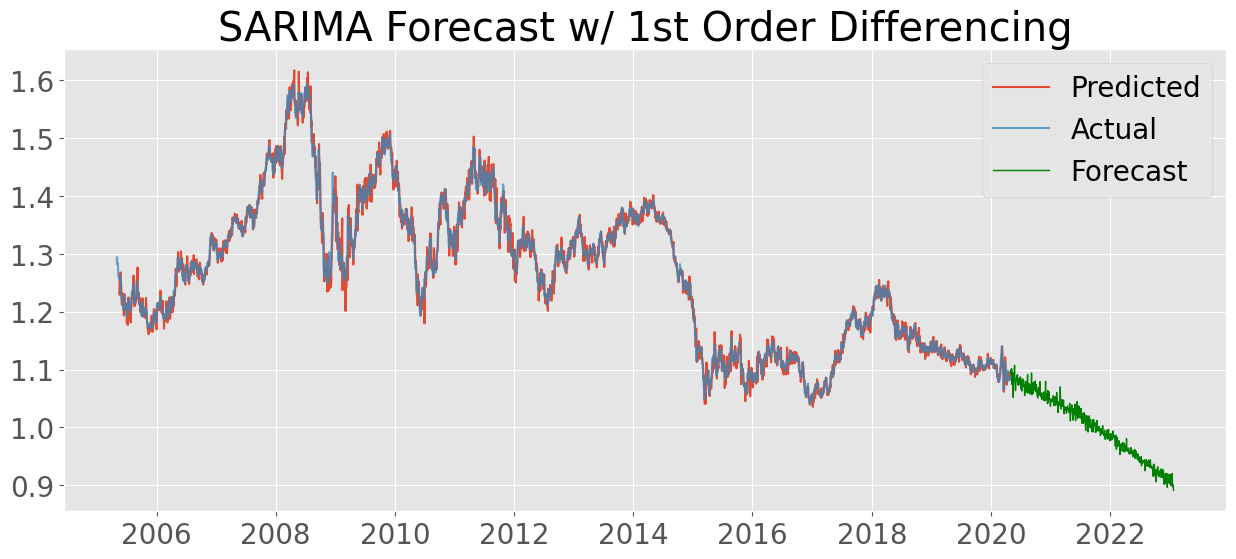

In [70]:
sdiff_model = SARIMAX(original_df, order=(1, 1, 0), seasonal_order=(8, 1, 3, 7), trend='c', enforce_invertibility=False)
sdiff_model_fit = sdiff_model.fit()

# Make predictions
sdiff_predictions = sdiff_model_fit.predict(start=0, end=len(original_df['BC'])-1, typ='levels')

# Add differenced values back to predictions to obtain original scale
for i in range(len(sdiff_predictions)):
    sdiff_predictions[i] = sdiff_predictions[i] + diff_df['BC'][-30+i]

# Generate future dates
sdiff_future_dates = pd.date_range(start='2020-05-01', periods=500, freq='2D')

# Use the SARIMAX model to forecast future values
sdiff_forecast = sdiff_model_fit.forecast(steps=500)

# Add differenced values back to forecast to obtain original scale
for i in range(len(sdiff_forecast)):
    sdiff_forecast[i] = sdiff_forecast[i] + diff_df['BC'][-30+i]

# Plot actual vs predicted values
plt.figure(figsize=(15,6))
plt.title('SARIMA Forecast w/ 1st Order Differencing')
plt.plot(original_df.index[8:], sdiff_predictions[8:], label='Predicted')
plt.plot(original_df.index, original_df, label='Actual', alpha=0.75)
plt.plot(sdiff_future_dates, sdiff_forecast, label='Forecast', linewidth=1,color='green')
plt.legend()
plt.show()

In [73]:
rmse_diff_sarima = sqrt(mean_squared_error(original_df,sdiff_predictions))
print('RMSE: ', rmse_diff_sarima)


from sklearn.metrics import r2_score
r2_diff_sarima = r2_score(original_df, sdiff_predictions)
print('R2: ', r2_diff_sarima)

y_true = original_df['BC'].iloc[-len(original_df):]

residuals = y_true - sdiff_predictions

# Calculate RSS
rss_diff_sarima = np.sum(residuals**2)
print("RSS:", rss_diff_sarima)

RMSE:  0.03016377295428889
R2:  0.943682079066096
RSS: 2.4920879116169803


# Build LSTM Model

### Train Test Spilt

In [74]:
window = 60

#### Original

In [75]:
# define as array and train 95% of data
original_dataset = original_df.values
training_data_len_orginal = math.ceil(len(original_dataset)*0.95)

In [76]:
# train data
original_train = original_dataset[0:training_data_len_orginal,:]
original_train.shape

(2603, 1)

In [77]:
# test data
original_test = original_dataset[(training_data_len_orginal-window):,:]
original_test.shape

(196, 1)

#### Scaled

In [78]:
# define as array and train 95% of data
scaled_dataset = scaled_df.values
training_data_len_scaled = math.ceil(len(scaled_dataset)*0.95)

In [79]:
# train data
scaled_train = scaled_dataset[0:training_data_len_scaled,:]
scaled_train.shape

(2603, 1)

In [80]:
# test data
scaled_test = scaled_dataset[(training_data_len_scaled-window):,:]
scaled_test.shape

(196, 1)

#### 1st Order Differencing

In [81]:
# define as array and train 95% of data
diff_dataset = diff_df.values
training_data_len_diff = math.ceil(len(diff_dataset)*0.95)

In [82]:
# set train data
diff_train = diff_dataset[0:training_data_len_diff,:]
diff_train.shape

(2602, 1)

In [83]:
# set test data
diff_test = diff_dataset[(training_data_len_diff-window):,:]
diff_test.shape

(196, 1)

#### Process train sets & test sets

In [84]:
# Create function to create dataset for LSTM model
def create_dataset(dataset, window):
    X, Y = [], []
    for i in range(len(dataset)-window):
        X.append(dataset[i:i+window])
        Y.append(dataset[i+window])
    return np.array(X), np.array(Y)

In [85]:
# Create train set for each dataset
X_train_original, Y_train_original = create_dataset(original_train, window)
X_train_scaled, Y_train_scaled = create_dataset(scaled_train, window)
X_train_diff, Y_train_diff = create_dataset(diff_train, window)

In [86]:
# Create test sets for each dataset
X_test_original, Y_test_original = create_dataset(original_test, window)
X_test_scaled, Y_test_scaled = create_dataset(scaled_test, window)
X_test_diff, Y_test_diff = create_dataset(diff_test, window)

In [87]:
# Reshape the input data for LSTM model
X_train_original = np.reshape(X_train_original, (X_train_original.shape[0], X_train_original.shape[1], 1))
X_test_original = np.reshape(X_test_original, (X_test_original.shape[0], X_test_original.shape[1], 1))


X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

X_train_diff = np.reshape(X_train_diff, (X_train_diff.shape[0], X_train_diff.shape[1], 1))
X_test_diff = np.reshape(X_test_diff, (X_test_diff.shape[0], X_test_diff.shape[1], 1))

# Reshape the output data for LSTM model
Y_train_original = Y_train_original.reshape(-1, 1)
Y_test_original = Y_test_original.reshape(-1, 1)

Y_train_scaled = Y_train_scaled.reshape(-1, 1)
Y_test_scaled = Y_test_scaled.reshape(-1, 1)

Y_train_diff = Y_train_diff.reshape(-1, 1)
Y_test_diff = Y_test_diff.reshape(-1, 1)

### LSTM on Original Data

#### Model Fit

In [88]:
# Build the LSTM model for original dataset
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_original.shape[1], 1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_original, Y_train_original, epochs=100, batch_size=64)

Epoch 1/100
40/40 [==============================] - 7s 82ms/step - loss: 0.1074
Epoch 2/100
40/40 [==============================] - 3s 81ms/step - loss: 0.0115
Epoch 3/100
40/40 [==============================] - 3s 82ms/step - loss: 0.0074
Epoch 4/100
40/40 [==============================] - 3s 82ms/step - loss: 0.0029
Epoch 5/100
40/40 [==============================] - 3s 81ms/step - loss: 9.2701e-04
Epoch 6/100
40/40 [==============================] - 3s 80ms/step - loss: 7.9537e-04
Epoch 7/100
40/40 [==============================] - 3s 80ms/step - loss: 7.5139e-04
Epoch 8/100
40/40 [==============================] - 3s 80ms/step - loss: 7.2431e-04
Epoch 9/100
40/40 [==============================] - 3s 80ms/step - loss: 7.8541e-04
Epoch 10/100
40/40 [==============================] - 3s 79ms/step - loss: 8.5979e-04
Epoch 11/100
40/40 [==============================] - 3s 80ms/step - loss: 0.0010
Epoch 12/100
40/40 [==============================] - 3s 79ms/step - loss: 6.7053e-

In [89]:
# Make predictions on test sets using LSTM model
pred_original = model.predict(X_test_original)

5/5 [==============================] - 1s 16ms/step


#### RMSE, R2, RSS

In [90]:
mse = mean_squared_error(Y_test_original, pred_original)
original_rSquare_lstm = metrics.r2_score(Y_test_original, pred_original)
original_rmse_lstm = np.sqrt(mse)
original_rss_lstm = np.sum(np.square(Y_test_original - pred_original))

print("Original Data Results")
print("RMSE: ", original_rmse_lstm)
print("R-Squared: ", original_rSquare_lstm)
print("RSS: ", original_rss_lstm)

Original Data Results
RMSE:  0.010412569539104233
R-Squared:  0.30035801132866136
RSS:  0.014745338199308665


#### Plot

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14888\981594939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_original['Predictions'] = pred_original


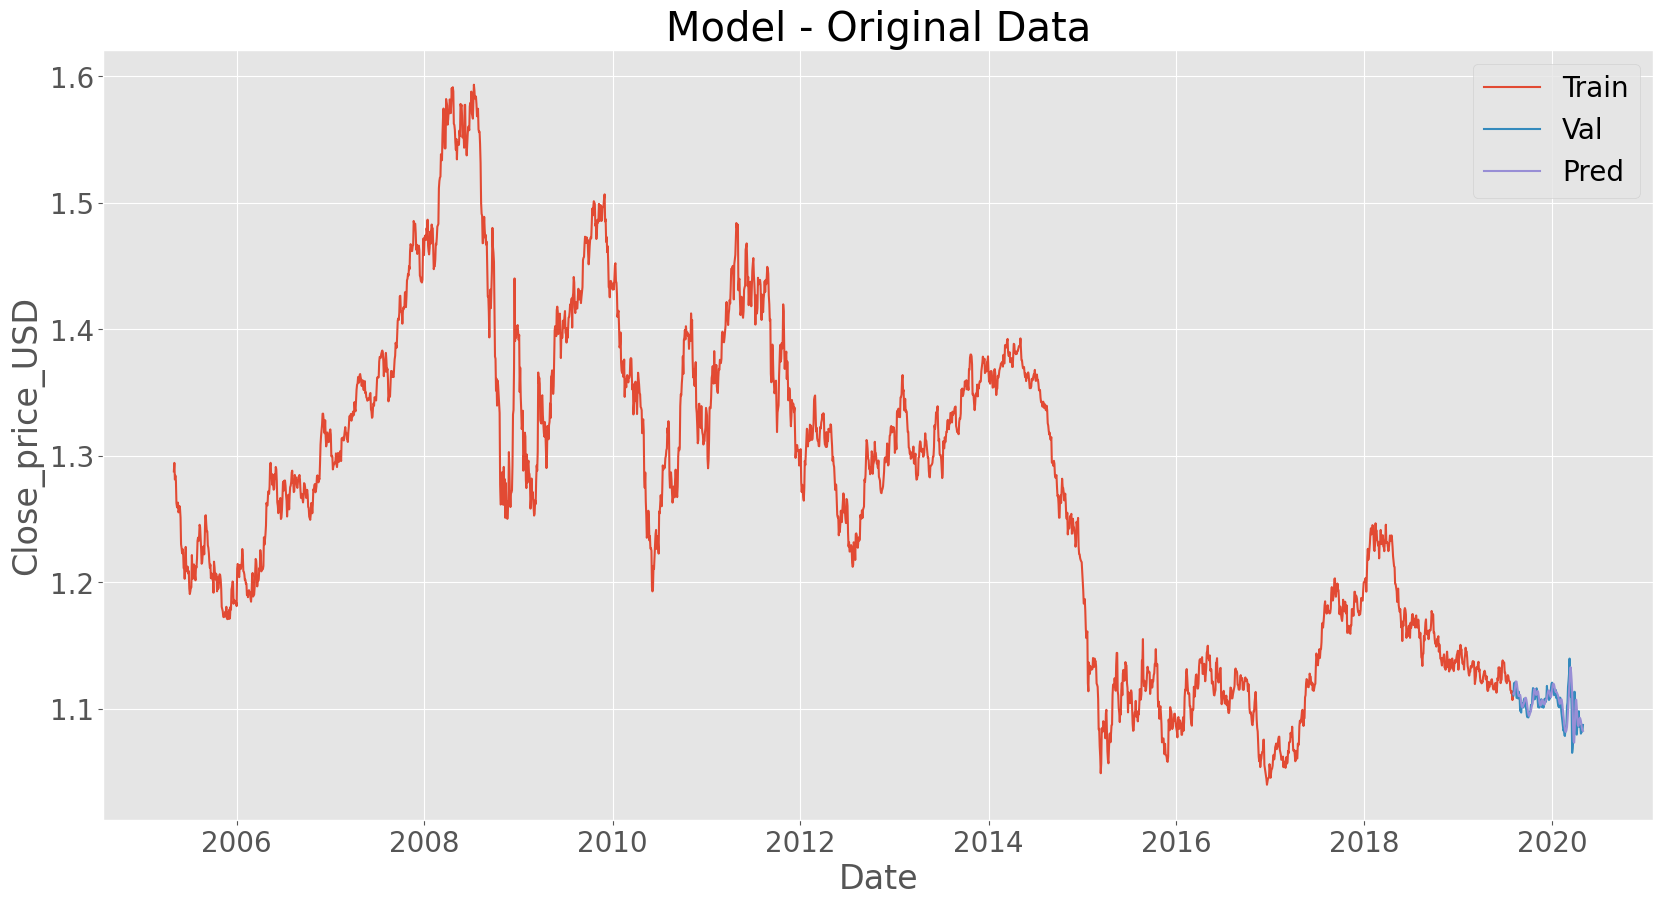

In [91]:
train_original = original_df[:training_data_len_orginal]
valid_original = original_df[training_data_len_orginal:]

valid_original['Predictions'] = pred_original

plt.figure(figsize=(20,10))
plt.title('Model - Original Data')
plt.xlabel('Date')
plt.ylabel('Close_price_USD')
plt.plot(train_original['BC'])
plt.plot(valid_original[['BC', 'Predictions']])
plt.legend(['Train', 'Val','Pred'])
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14888\1648862463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_original['Predictions'] = pred_original


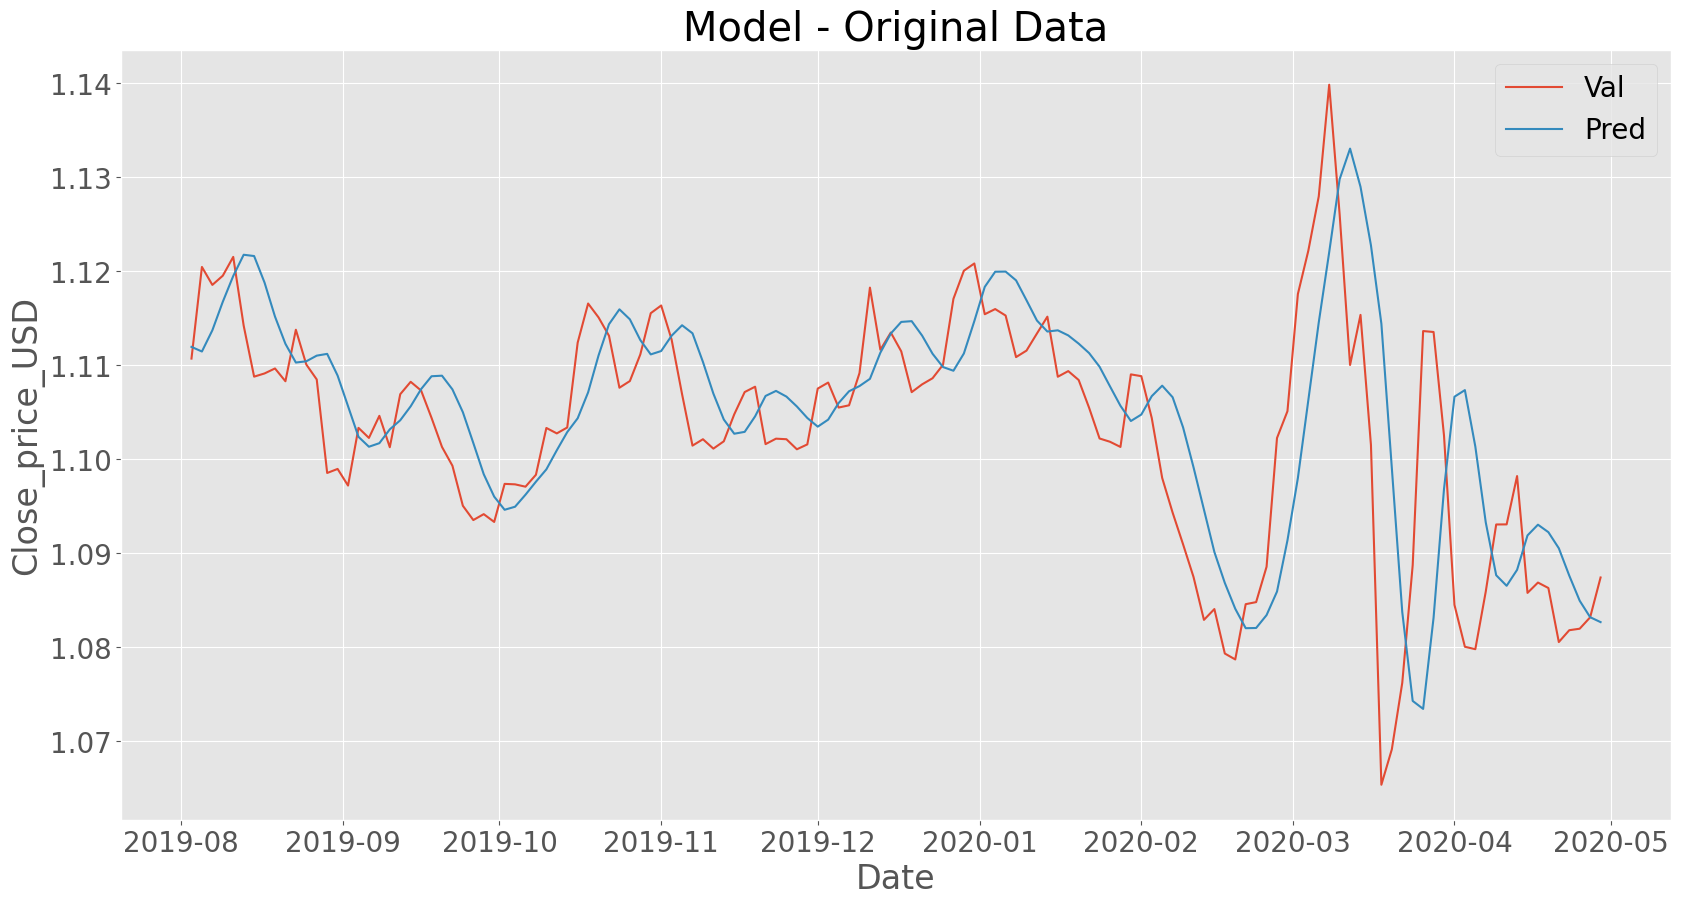

In [92]:
train_original = original_df[:training_data_len_orginal]
valid_original = original_df[training_data_len_orginal:]

valid_original['Predictions'] = pred_original

plt.figure(figsize=(20,10))
plt.title('Model - Original Data')
plt.xlabel('Date')
plt.ylabel('Close_price_USD')
plt.plot(valid_original[['BC', 'Predictions']])
plt.legend(['Val','Pred'])
plt.show()

### LSTM on Scaled Data

#### Model Fit

In [93]:
# Build the LSTM model for scaled dataset
#units = number of neurons 神经元数量
#model_scaled.add(LSTM()) = level of LSTM
model_scaled = Sequential()
model_scaled.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model_scaled.add(LSTM(units=50,return_sequences=True))
model_scaled.add(LSTM(units=25))
model_scaled.add(Dense(1))

# Compile the model
model_scaled.compile(optimizer='adam', loss='mean_squared_error')
model_scaled.fit(X_train_scaled, Y_train_scaled, epochs=100, batch_size=64)

Epoch 1/100
40/40 [==============================] - 7s 76ms/step - loss: 0.0241
Epoch 2/100
40/40 [==============================] - 3s 74ms/step - loss: 0.0023
Epoch 3/100
40/40 [==============================] - 3s 74ms/step - loss: 0.0020
Epoch 4/100
40/40 [==============================] - 3s 74ms/step - loss: 0.0019
Epoch 5/100
40/40 [==============================] - 3s 73ms/step - loss: 0.0016
Epoch 6/100
40/40 [==============================] - 3s 73ms/step - loss: 0.0016
Epoch 7/100
40/40 [==============================] - 3s 76ms/step - loss: 0.0014
Epoch 8/100
40/40 [==============================] - 3s 78ms/step - loss: 0.0012
Epoch 9/100
40/40 [==============================] - 3s 78ms/step - loss: 0.0012
Epoch 10/100
40/40 [==============================] - 3s 74ms/step - loss: 0.0011
Epoch 11/100
40/40 [==============================] - 3s 79ms/step - loss: 0.0010
Epoch 12/100
40/40 [==============================] - 3s 77ms/step - loss: 9.0909e-04
Epoch 13/100
40/40 [=

In [94]:
pred_scaled = model_scaled.predict(X_test_scaled)

5/5 [==============================] - 1s 15ms/step


#### RMSE, R2, RSS

In [95]:
mse = mean_squared_error(Y_test_scaled, pred_scaled)
scaled_rSquare_lstm = metrics.r2_score(Y_test_scaled, pred_scaled)
scaled_rmse_lstm = np.sqrt(mse)
scaled_rss_lstm = np.sum(np.square(Y_test_scaled - pred_scaled))

print("Scaled Data Results")
print("RMSE: ", scaled_rmse_lstm)
print("R-Squared: ", scaled_rSquare_lstm)
print("RSS: ", scaled_rss_lstm)

Scaled Data Results
RMSE:  0.01271154058233586
R-Squared:  0.6809736586956188
RSS:  0.021975323900786523


#### Plot

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14888\4169401920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_scaled['Predictions'] = pred_scaled


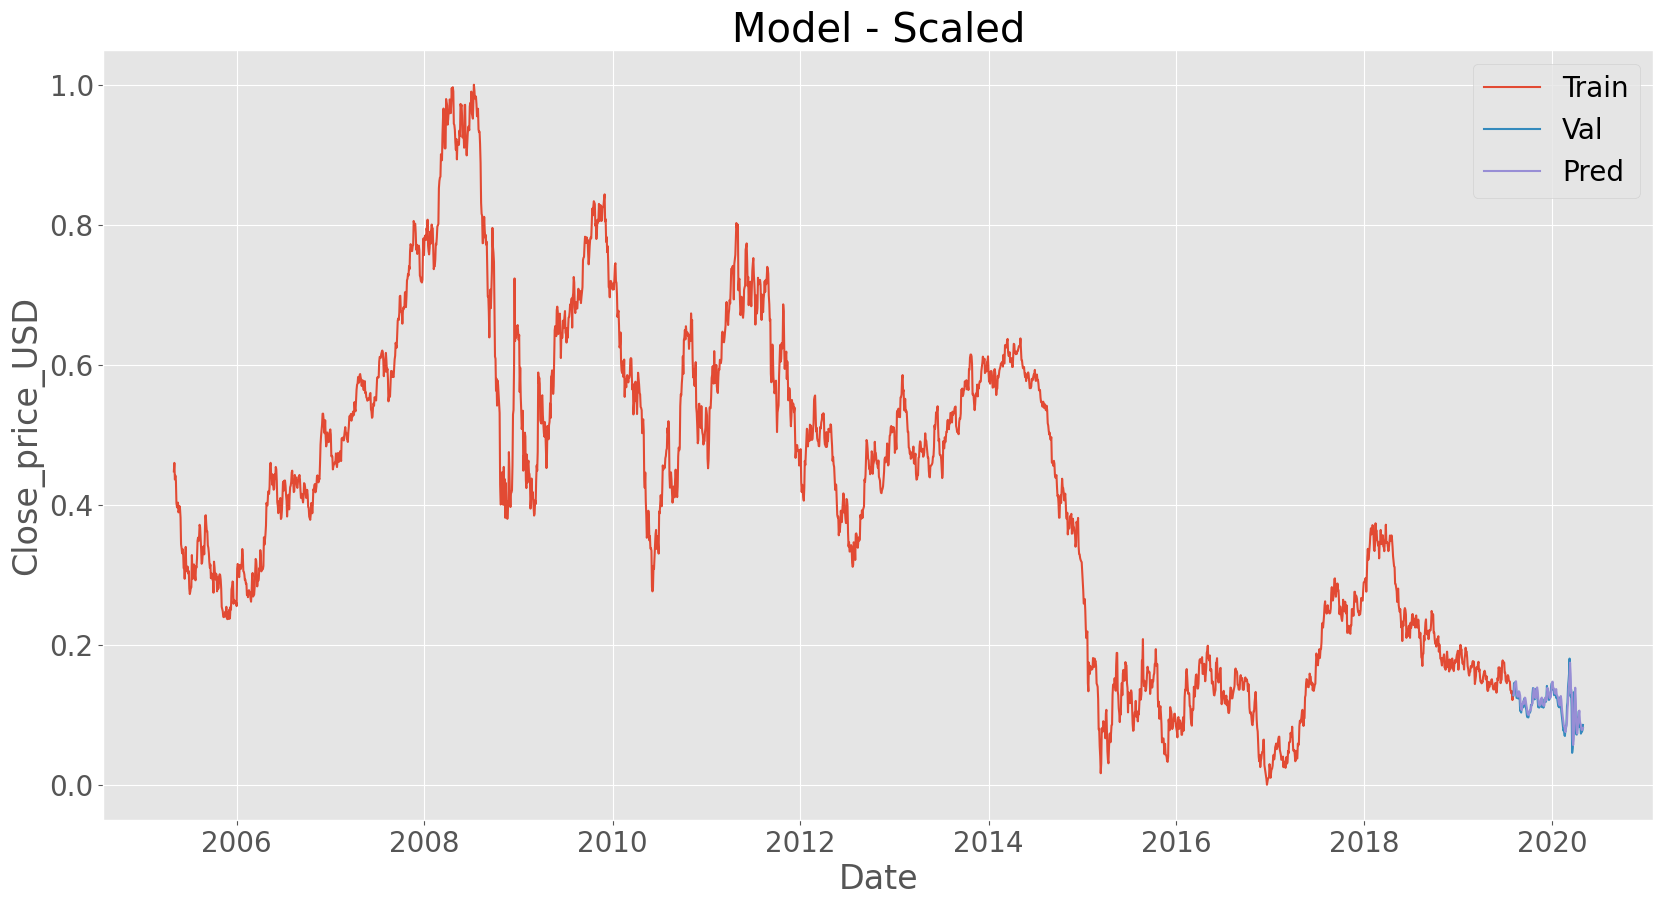

In [96]:
train_scaled = scaled_df[:training_data_len_scaled]
valid_scaled = scaled_df[training_data_len_scaled:]

valid_scaled['Predictions'] = pred_scaled

plt.figure(figsize=(20,10))
plt.title('Model - Scaled')
plt.xlabel('Date')
plt.ylabel('Close_price_USD')
plt.plot(train_scaled['BC'])
plt.plot(valid_scaled[['BC', 'Predictions']])
plt.legend(['Train', 'Val','Pred'])
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14888\773171931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_scaled['Predictions'] = pred_scaled


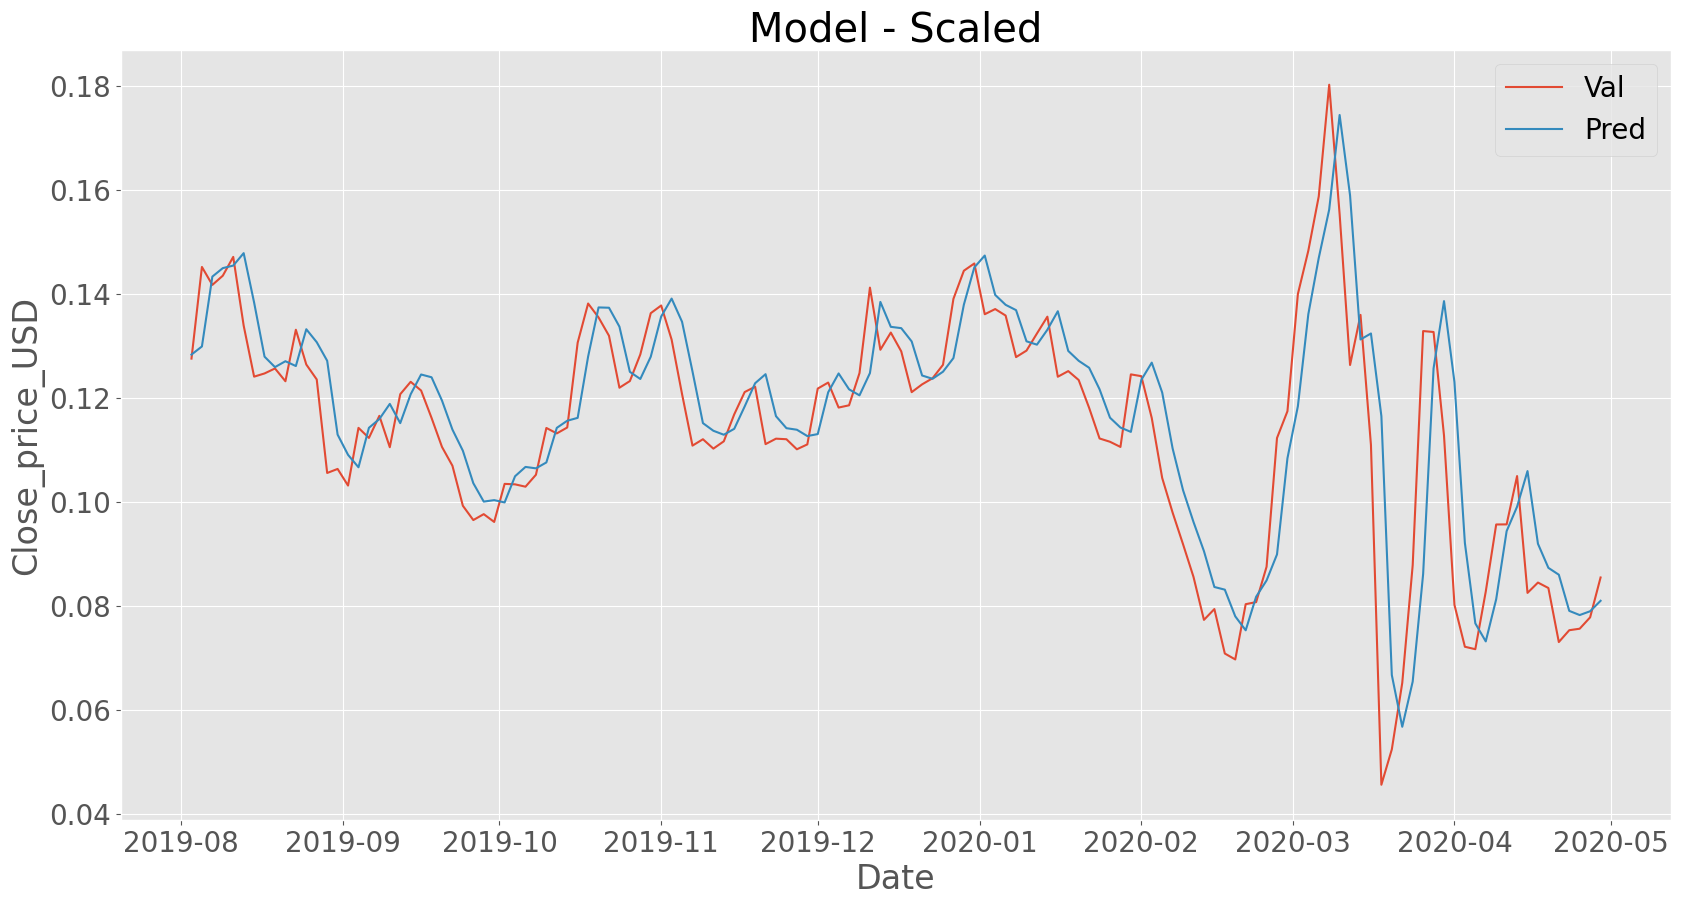

In [97]:
train_scaled = scaled_df[:training_data_len_scaled]
valid_scaled = scaled_df[training_data_len_scaled:]

valid_scaled['Predictions'] = pred_scaled

plt.figure(figsize=(20,10))
plt.title('Model - Scaled')
plt.xlabel('Date')
plt.ylabel('Close_price_USD')
plt.plot(valid_scaled[['BC', 'Predictions']])
plt.legend(['Val','Pred'])
plt.show()

### LSTM on Differenced Data

#### Model Fit

In [98]:
# Build the LSTM model for diff dataset
#units = number of neurons 神经元数量
#model_diff.add(LSTM()) = level of LSTM
model_diff = Sequential()
model_diff.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_diff.shape[1], 1)))
model_diff.add(LSTM(units=50,return_sequences=True))
model_diff.add(LSTM(units=25))
model_diff.add(Dense(1))

# Compile the model
model_diff.compile(optimizer='adam', loss='mean_squared_error')
model_diff.fit(X_train_diff, Y_train_diff, epochs=100, batch_size=64)

Epoch 1/100
40/40 [==============================] - 7s 79ms/step - loss: 1.1163e-04
Epoch 2/100
40/40 [==============================] - 3s 79ms/step - loss: 8.8035e-05
Epoch 3/100
40/40 [==============================] - 3s 78ms/step - loss: 8.6502e-05
Epoch 4/100
40/40 [==============================] - 3s 82ms/step - loss: 8.7163e-05
Epoch 5/100
40/40 [==============================] - 3s 83ms/step - loss: 8.7105e-05
Epoch 6/100
40/40 [==============================] - 3s 78ms/step - loss: 8.6863e-05
Epoch 7/100
40/40 [==============================] - 3s 77ms/step - loss: 8.8753e-05
Epoch 8/100
40/40 [==============================] - 3s 77ms/step - loss: 8.9563e-05
Epoch 9/100
40/40 [==============================] - 3s 82ms/step - loss: 8.6922e-05
Epoch 10/100
40/40 [==============================] - 3s 81ms/step - loss: 8.7671e-05
Epoch 11/100
40/40 [==============================] - 3s 85ms/step - loss: 8.8118e-05
Epoch 12/100
40/40 [==============================] - 3s 80ms/s

In [99]:
pred_diff = model_diff.predict(X_test_diff)

5/5 [==============================] - 1s 16ms/step


#### RMSE, R2, RSS

In [100]:
mse = mean_squared_error(Y_test_diff, pred_diff)
diff_rSquare_lstm = metrics.r2_score(Y_test_diff, pred_diff)
diff_rmse_lstm = np.sqrt(mse)
diff_rss_lstm = np.sum(np.square(Y_test_diff - pred_diff))

print("Diff Data Results")
print("RMSE: ", diff_rmse_lstm)
print("R-Squared: ", diff_rSquare_lstm)
print("RSS: ", diff_rss_lstm)

Diff Data Results
RMSE:  0.0064249417164100545
R-Squared:  -0.0026844668220196155
RSS:  0.005614063144060201


#### Plot

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14888\2469647709.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_diff['Predictions'] = pred_diff


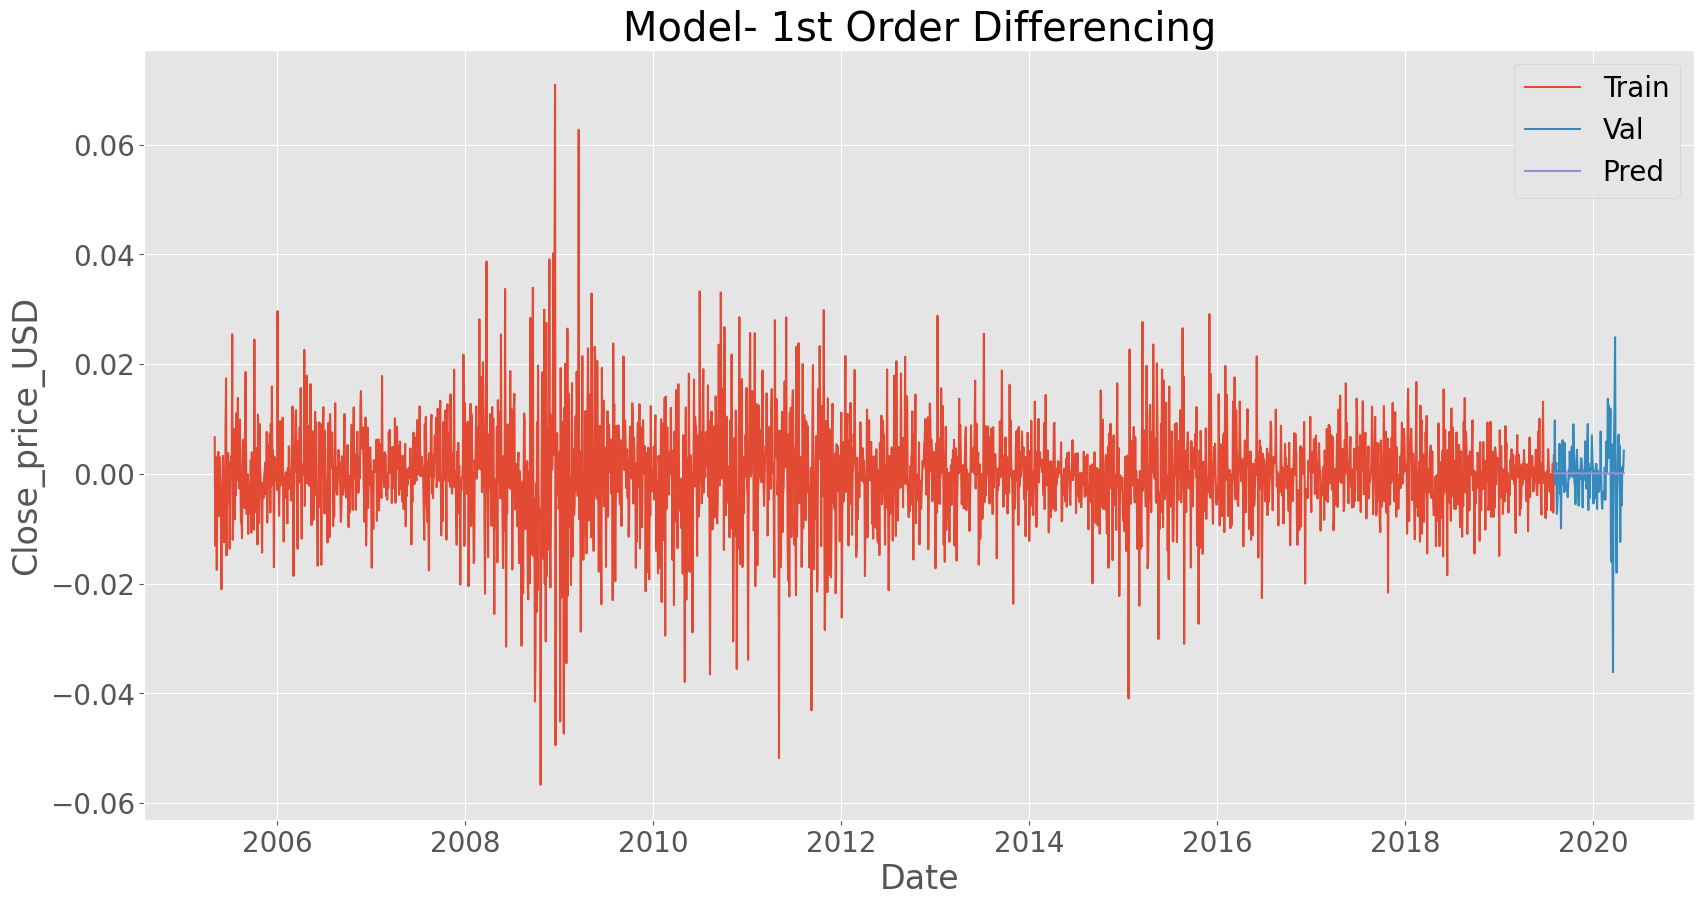

In [101]:
train_diff = diff_df[:training_data_len_diff]
valid_diff = diff_df[training_data_len_diff:]

valid_diff['Predictions'] = pred_diff

plt.figure(figsize=(20,10))
plt.title('Model- 1st Order Differencing')
plt.xlabel('Date')
plt.ylabel('Close_price_USD')
plt.plot(train_diff['BC'])
plt.plot(valid_diff[['BC', 'Predictions']])
plt.legend(['Train', 'Val','Pred'])
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14888\3703991785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_diff['Predictions'] = pred_diff


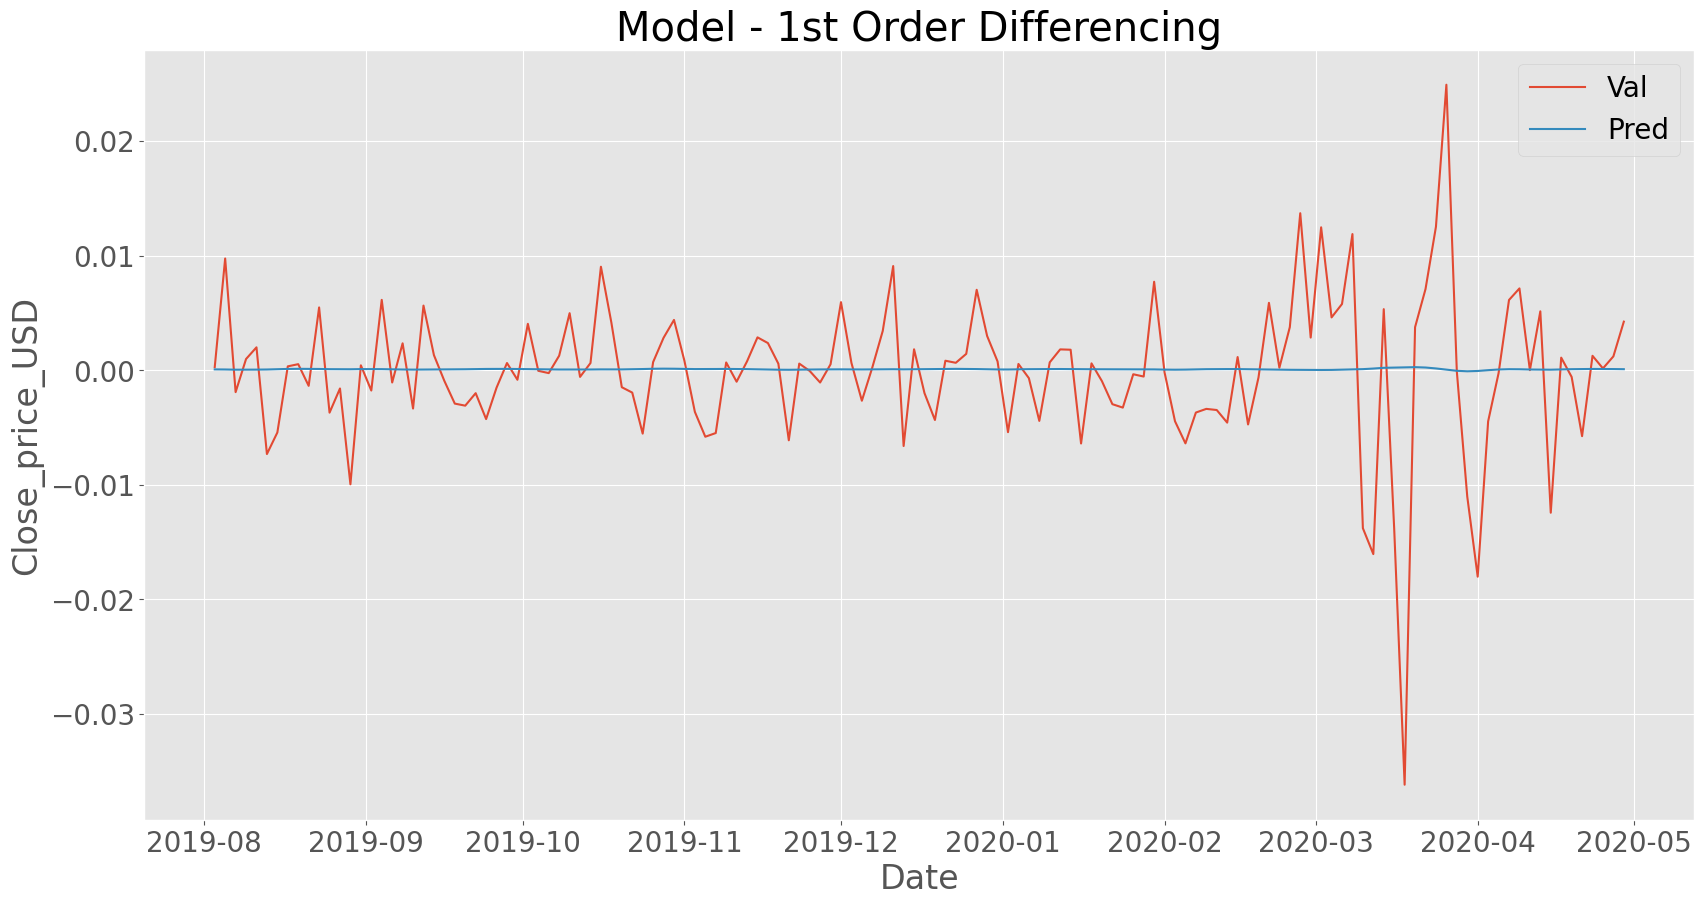

In [102]:
train_diff = diff_df[:training_data_len_diff]
valid_diff = diff_df[training_data_len_diff:]

valid_diff['Predictions'] = pred_diff

plt.figure(figsize=(20,10))
plt.title('Model - 1st Order Differencing')
plt.xlabel('Date')
plt.ylabel('Close_price_USD')
plt.plot(valid_diff[['BC', 'Predictions']])
plt.legend(['Val','Pred'])
plt.show()

# Evaluate Model

### Original Dataset

            RMSE       RSS  R-Squared
ARIMA   0.026891  1.881546   0.953488
SARIMA  0.029121  2.322733   0.947509
LSTM    0.010413  0.014745   0.300358


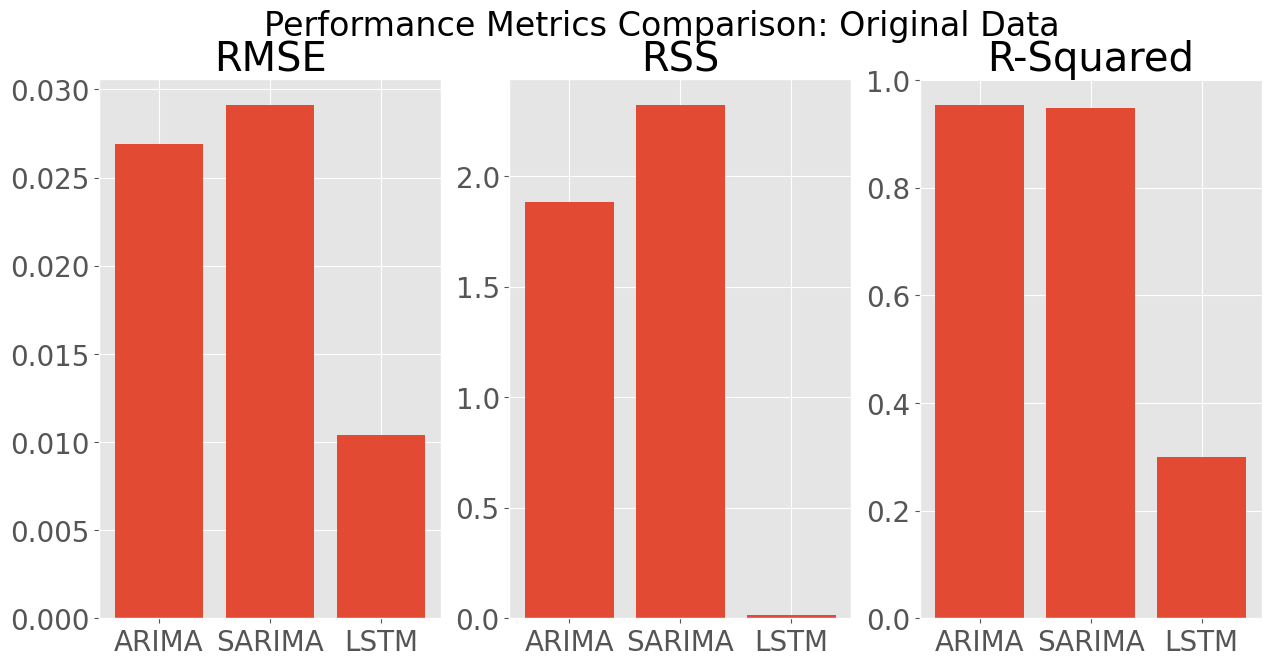

In [103]:
# Combine all metrics into a single DataFrame
metrics = pd.DataFrame({
    'RMSE': [rmse_original_arima, rmse_original_sarima, original_rmse_lstm],
    'RSS': [rss_original_arima, rss_original_sarima, original_rss_lstm],
    'R-Squared': [r2_original_arima, r2_original_sarima, original_rSquare_lstm]
}, index=['ARIMA', 'SARIMA', 'LSTM'])

# Plot all metrics on a single row of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Set common title for all subplots
fig.suptitle('Performance Metrics Comparison: Original Data')

# Iterate over columns and plot each metric
for i, col in enumerate(metrics.columns):
    axs[i].bar(metrics.index, metrics[col])
    axs[i].set_title(col)

print(metrics)

plt.show()

### Scaled Dataset

            RMSE       RSS  R-Squared
ARIMA   0.018899  0.929408   0.992970
SARIMA  0.011929  0.389770   0.991192
LSTM    0.012712  0.021975   0.680974


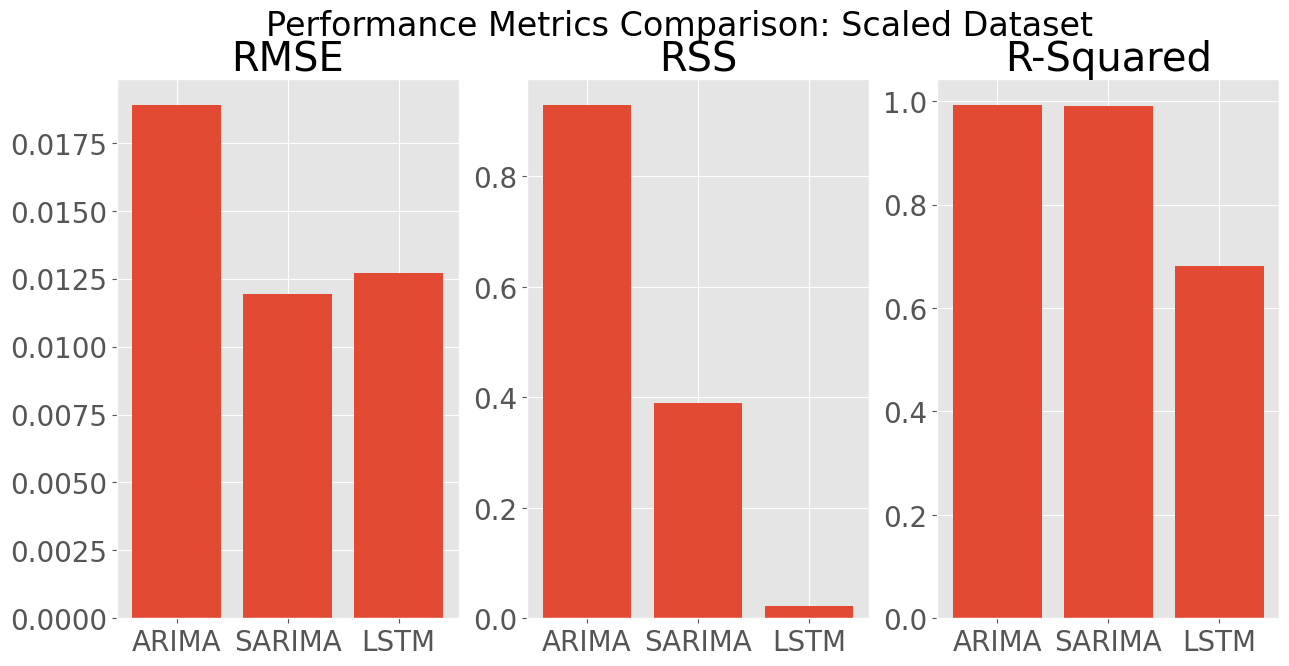

In [108]:
# Combine all metrics into a single DataFrame
scaled_metrics = pd.DataFrame({
    'RMSE': [rmse_scaled_arima, rmse_scaled_sarima, scaled_rmse_lstm],
    'RSS': [rss_scaled_arima, rss_scaled_sarima, scaled_rss_lstm],
    'R-Squared': [r2_scaled_arima, r2_scaled_sarima, scaled_rSquare_lstm]
}, index=['ARIMA', 'SARIMA', 'LSTM'])

# Plot all metrics on a single row of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Set common title for all subplots
fig.suptitle('Performance Metrics Comparison: Scaled Dataset')

# Iterate over columns and plot each metric
for i, col in enumerate(scaled_metrics.columns):
    axs[i].bar(scaled_metrics.index, scaled_metrics[col])
    axs[i].set_title(col)

print(scaled_metrics)

plt.show()

### Differenced Values

            RMSE       RSS  R-Squared
ARIMA   0.009325  0.226171  -0.014098
SARIMA  0.030164  2.492088   0.943682
LSTM    0.006425  0.005614  -0.002684


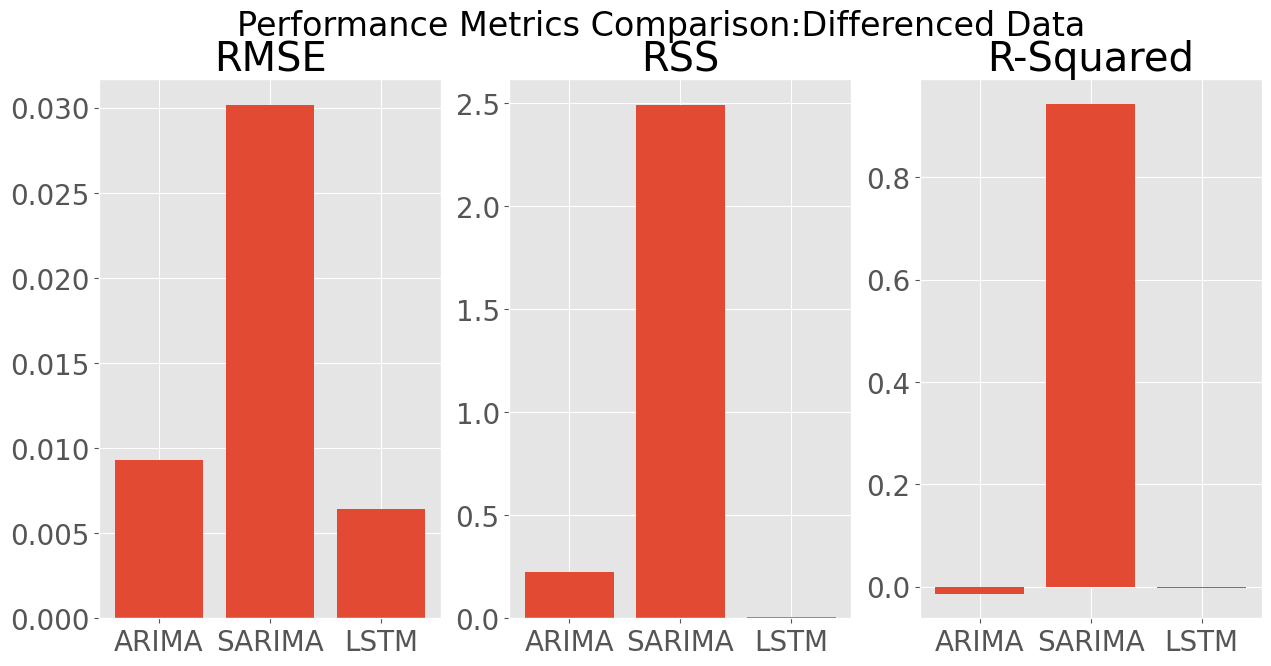

In [109]:
# Combine all metrics into a single DataFrame
diff_metrics = pd.DataFrame({
    'RMSE': [rmse_diff_arima, rmse_diff_sarima, diff_rmse_lstm],
    'RSS': [rss_diff_arima, rss_diff_sarima, diff_rss_lstm],
    'R-Squared': [r2_diff_arima, r2_diff_sarima, diff_rSquare_lstm]
}, index=['ARIMA', 'SARIMA', 'LSTM'])

# Plot all metrics on a single row of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Set common title for all subplots
fig.suptitle('Performance Metrics Comparison:Differenced Data')

# Iterate over columns and plot each metric
for i, col in enumerate(diff_metrics.columns):
    axs[i].bar(diff_metrics.index, diff_metrics[col])
    axs[i].set_title(col)

print(diff_metrics)

plt.show()